# Builidng Functional Connectivity Matrices

In [1]:
import seaborn as sns
import pandas as pd
import os, glob
from nilearn.connectome import ConnectivityMeasure
import numpy as np
from matplotlib import pyplot as plt
from nilearn import plotting
from nilearn.plotting import plot_connectome


In [2]:
# Helper Functions

"""
# Combine Timeseries
"""

# Combine Timeseries into a matrix by subject/condition
def timeseries_concat(subject_id, task,verbose=False, run_process=False):
    
    #for subject_id in subject_ids:
        
        #tasks=list(data_dict[subject_id].keys())
        
        #for task in tasks:
            

        #print(subject_id, task, stim)
        #print(os.path.join(beta_path, 'rois/big300/%s'%stim))
        # get roi texts for subject / condition
    roi_files = glob.glob(os.path.join(data_path, 'timeseries/bigbrain300/funcs_uc/region_rois/%s*%s*.txt'%(subject_id,task)))

    df_lst=[]
    #print(roi_files)


    try:
        for txt in roi_files: 
            #print(txt)
            df_temp = pd.read_csv(txt, sep="\n", header=None)
            #print(df_temp)
            df_lst.append(df_temp)
        #print(subject_id, task, len(df_lst))

        df_concat= pd.concat(df_lst, axis=1, sort=False)
        #print(df_concat)

        # write output file 
        
        #/projects/niblab/experiments/bbx/data/timeseries/bigbrain300/funcs_uc/matrices
        outfolder=os.path.join(data_path,'timeseries/bigbrain300/funcs_uc/matrices/runs')

        
        if "resting" in task:
            task="task-resting"
        else:
            task="task-training_%s"%task
            
        outfile=os.path.join(data_path, outfolder,'%s_ses-1_%s_bb300.txt'%(subject_id,task))
        if verbose==True:
            print('[PROCESSING] making file %s....'%outfile)
        if run_process ==True:
            df_concat.to_csv(outfile, header=None, index=None, sep='\t')
    except:
        pass
        error_subjects.append((subject_id,task))

    #if error_subjects: print(error_subjects)
    return error_subjects;

"""
# Make Individual Subject Connectivity Matrices
"""

def make_subject_fcm(subj_id,task,correlations, save_files=False, heatmap=False, connectome=False,verbose=False):
    
    if subj_id not in fc_corr_dict:
        fc_corr_dict[subj_id] = {}

    if subj_id not in subj_list:
        subj_list.append(subj_id)
            
    matrix_folder=os.path.join(data_path,'timeseries/bigbrain300/funcs_uc/matrices/runs')
    roi_matrices =glob.glob(os.path.join(matrix_folder, '%s*%s*.txt'%(subj_id,task)))
    #print(roi_matrices)
    
    
    for matrix in roi_matrices:
        
        filename = matrix.split("/")[-1] #"%s_ses-1_%s.txt"%(subj_id, task_id)
        #print("\n[INFO] Subject Matrix: %s "%filename)
        
        title_str=filename.split(".")[0]

        try:
            # we load the text file timeseries into an array 
            np_arr = np.loadtxt(matrix)
            #print(np_arr)


            # call fit_transform from ConnectivityMeasure object
            correlation_matrix = connectome_measure.fit_transform([np_arr])#[0]
            correlations.append(correlation_matrix)
            #print('[INFO] CORRELATION: ', correlation_matrix)#.shape)
            #print('[INFO] %s \tTask Mean: %s \tTask Std: %s'%(subj_id, round(np.mean(correlation_matrix),2), 
             #                       round(np.std(correlation_matrix),2)))
            
            #np.fill_diagonal(correlation_matrix, 0)
            
            # Make outfile path for subject/condition fcms 
            outfile=os.path.join(data_path, 'timeseries/bigbrain300/funcs_uc/matrices/fcms', '%s_fcm.txt'%filename.replace('.txt',''))
            #print("[INFO] Outfile: {}".format(outfile))

            if heatmap==True:
                # plot subject correlation matrix
                # Mask out the major diagonal

                plotting.plot_matrix(correlation_matrix, cmap=cmap, colorbar=True,title=title_str)#, tri='lower')
            
            if connectome==True:
                # We threshold to keep only the 20% of edges with the highest value
                # because the graph is very dense
                plotting.plot_connectome(correlation_matrix, coords_list, edge_threshold="90%", title=title_str)

            # do I save the files?
            if save_files==True:
                #print("[INFO] Outfile: {}".format(outfile))

                # save correlation as textfile
                np.savetxt(outfile, correlation_matrix.transpose(2,0,1).reshape(3,-1))
                
                if verbose==True:
                    print("[INFO] Outfile: {}".format(outfile))
            
            
        except:
            bad_subjects.append(subj_id)
            pass
    #print("[INFO] completed process")
    return correlations;
    
    
    
"""
# Setup the dictionary
"""    
def setup_dictionary(data_path, initialize=False, roi_ct=False):
    if initialize==True:
        data_dict={}

        # Fill dictionary 
        for func_file in functional_niis:
            #print(func_file.split("/")[-1])
            subj_id = func_file.split("/")[-1].split("_")[0]
            if "resting" in func_file:
                task_id="resting"
            else:
                task_id = func_file.split("/")[-1].split("_")[3]
            #print(subj_id, task_id)
            if subj_id not in data_dict:
                data_dict[subj_id]={}
            if task_id not in data_dict[subj_id]:
                data_dict[subj_id][task_id]={}


        print("[INFO] Dictionary made, {} keys".format(len(data_dict.keys())))
        
    if roi_ct==True:
        # Check for subjects with all 300 regions pulled
        # save the roi ct in the dictionary under tag 'bb300'

        for subject in data_dict.keys():
            for task in data_dict[subject].keys():
                task_files=glob.glob(os.path.join(data_path, 'timeseries/bigbrain300/funcs_uc/region_rois/%s*%s*.txt'%(subject, task)))
                data_dict[subject][task]['bb300'] = len(task_files)

    return data_dict;






In [3]:
error_subjects=[]
data_path='/projects/niblab/experiments/bbx/data'


In [4]:
# get functionals 
subjects=glob.glob(os.path.join(data_path, "preprocessed/sub-*/ses-1"))
print("Subjects found: {}".format(len(subjects)))

functional_niis=glob.glob(os.path.join(data_path, "preprocessed/sub-*/ses-1/func/*brain.nii.gz"))
print("Functional nifti files found: {}".format(len(functional_niis)))



Subjects found: 129
Functional nifti files found: 636


In [5]:
data_dict=setup_dictionary(data_path,initialize=True, roi_ct=True)


[INFO] Dictionary made, 129 keys



[INFO] sub-001 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.3


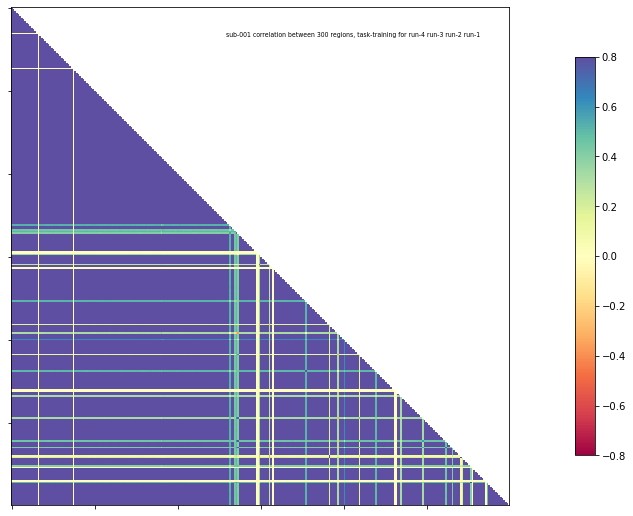


[INFO] sub-002 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.31


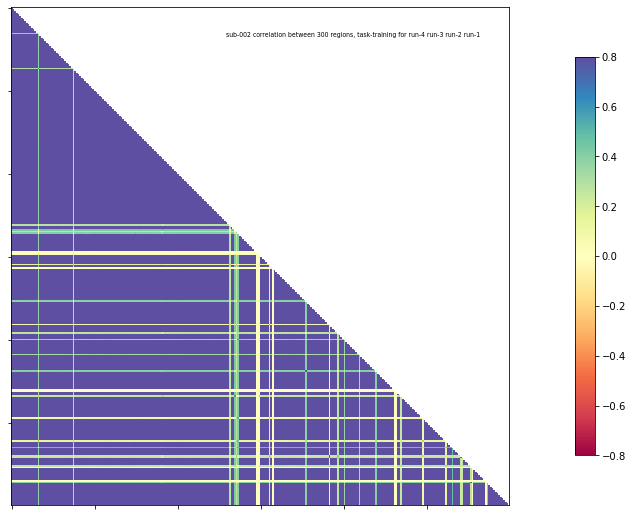


[INFO] sub-003 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.87 	Std: 0.27


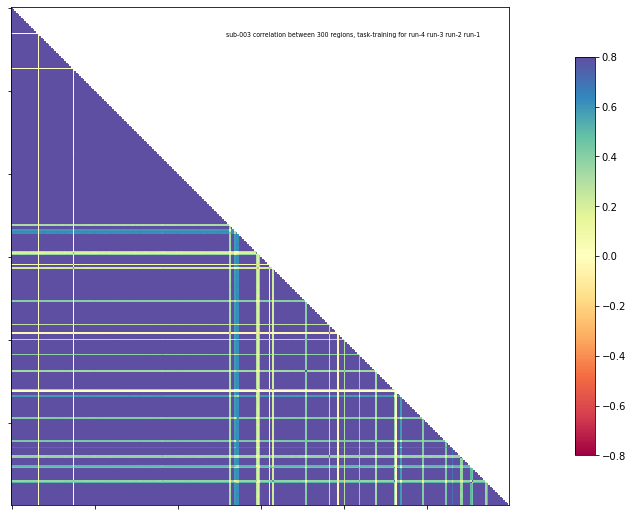


[INFO] sub-004 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.29


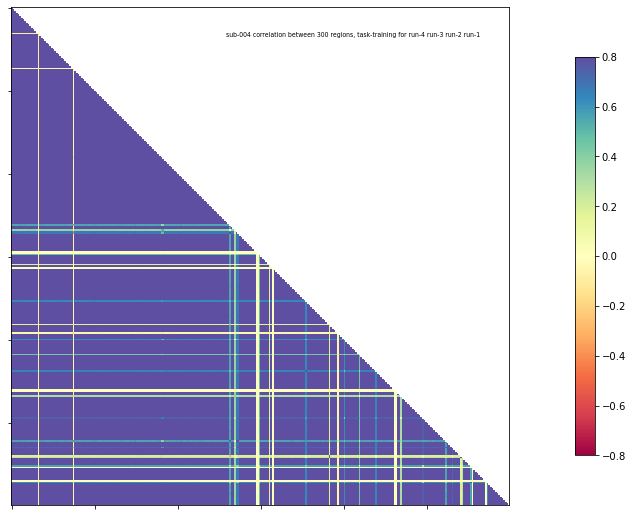


[INFO] sub-005 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.28


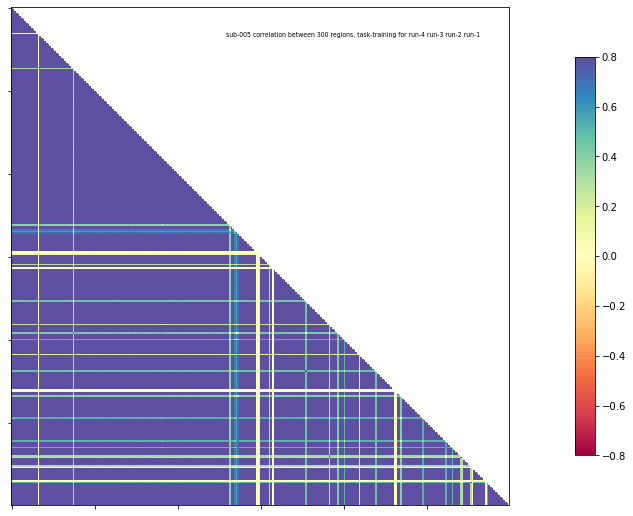


[INFO] sub-006 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.32


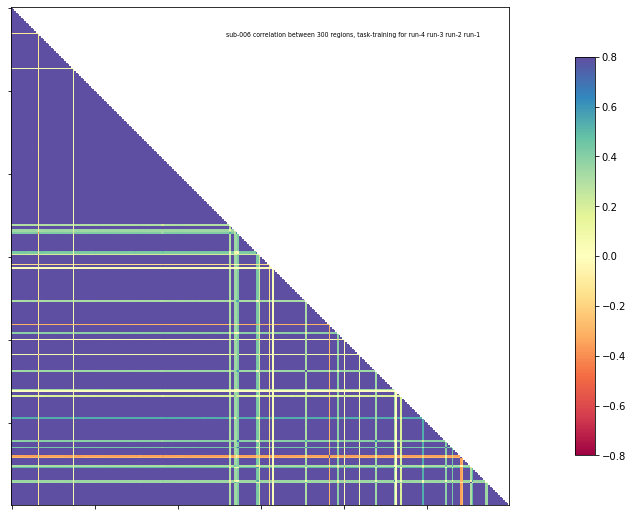


[INFO] sub-007 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.29


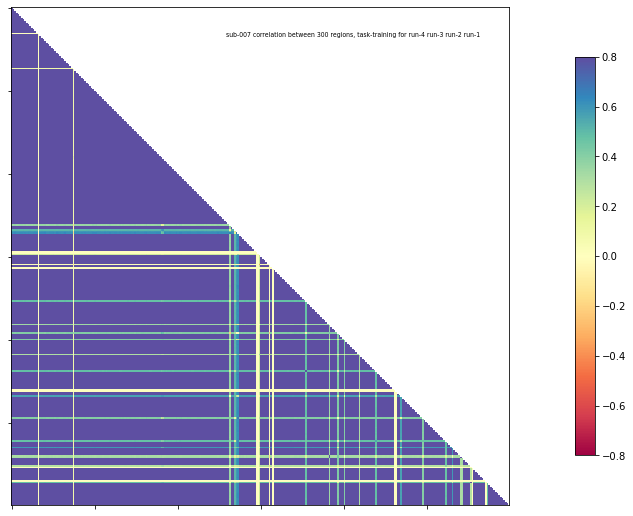


[INFO] sub-008 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.83 	Std: 0.3


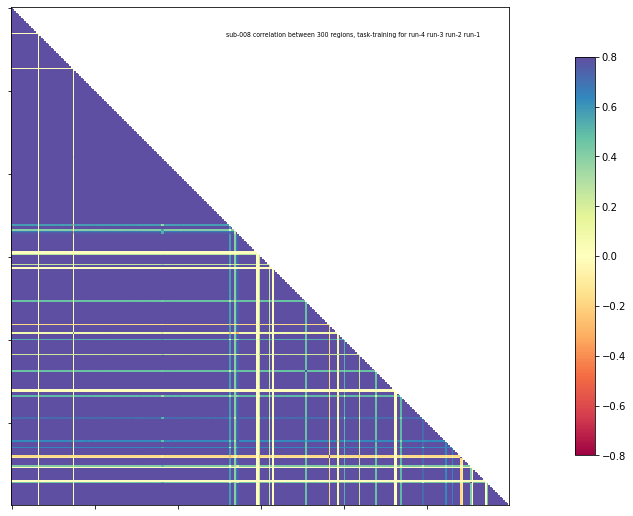


[INFO] sub-009 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.27


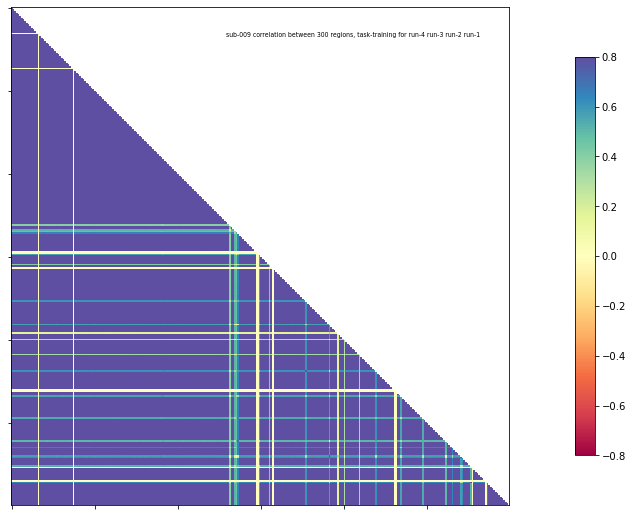


[INFO] sub-010 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.29


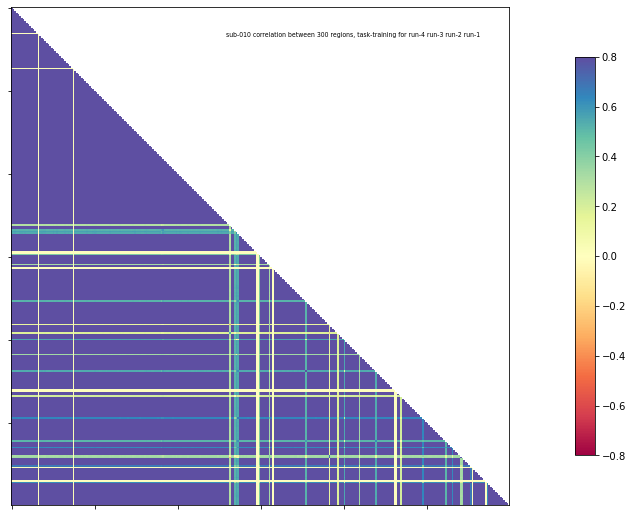


[INFO] sub-011 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


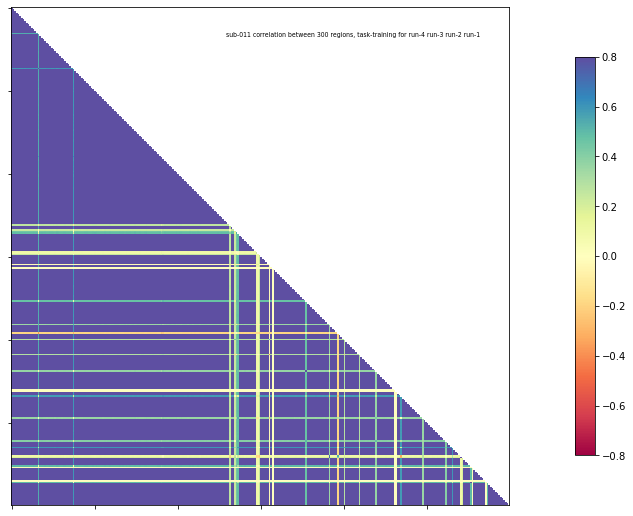


[INFO] sub-012 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.28


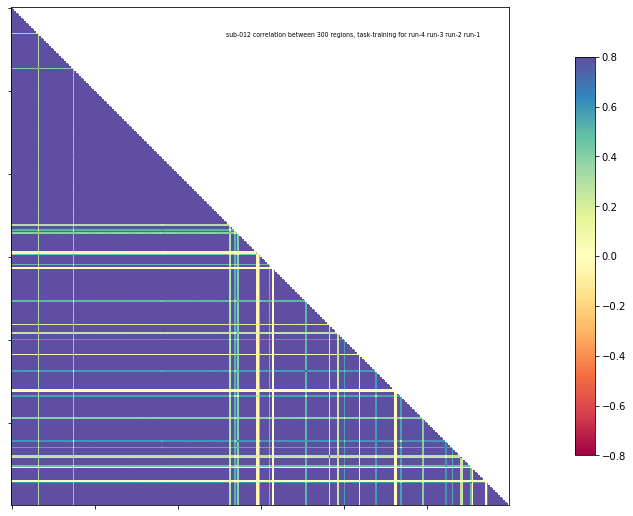


[INFO] sub-013 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.27


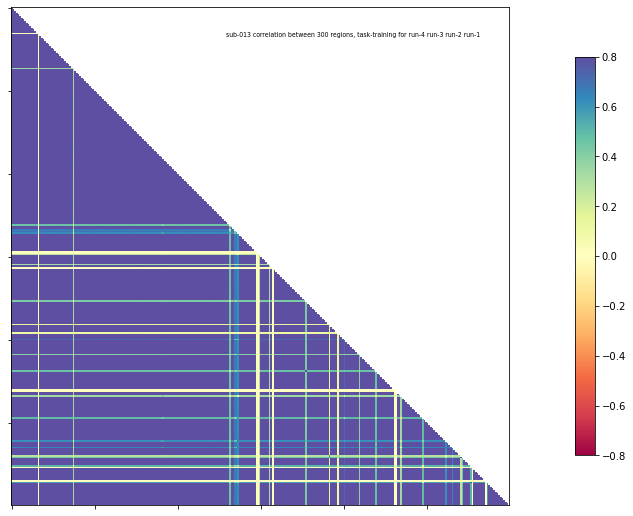


[INFO] sub-014 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.29


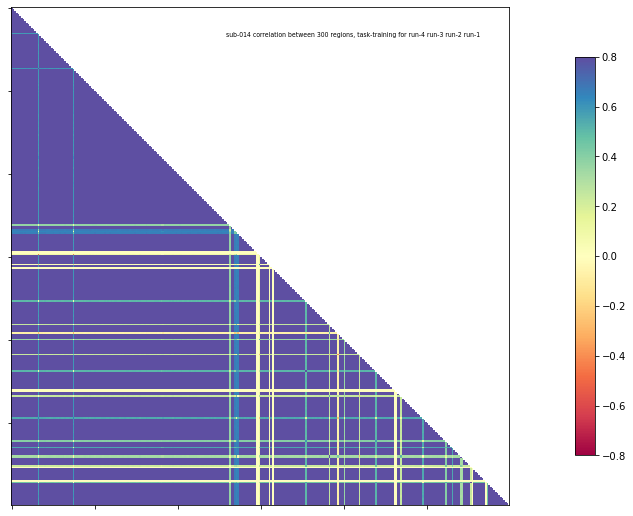


[INFO] sub-015 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.31


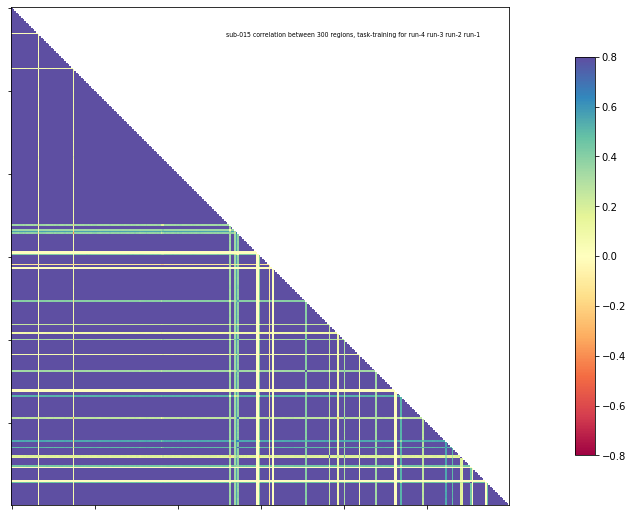


[INFO] sub-016 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.29


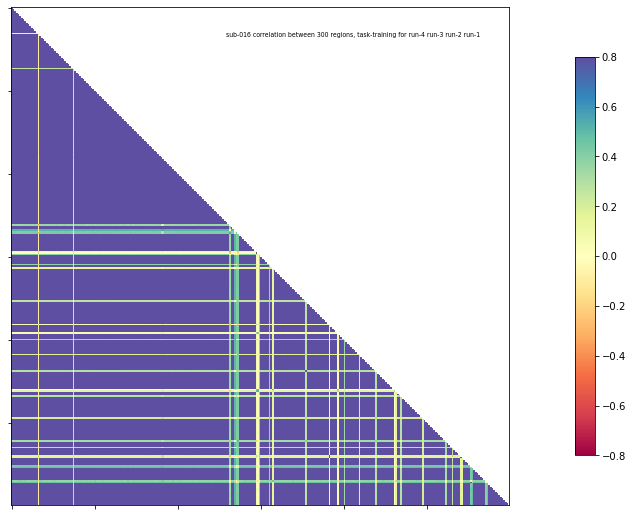


[INFO] sub-017 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.3


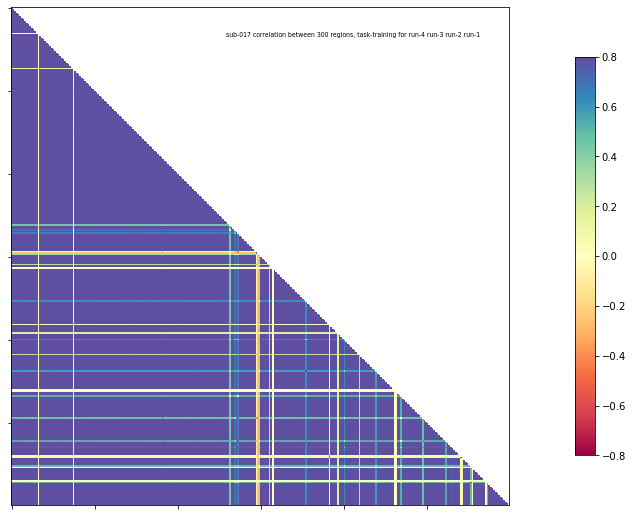


[INFO] sub-018 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.77 	Std: 0.27


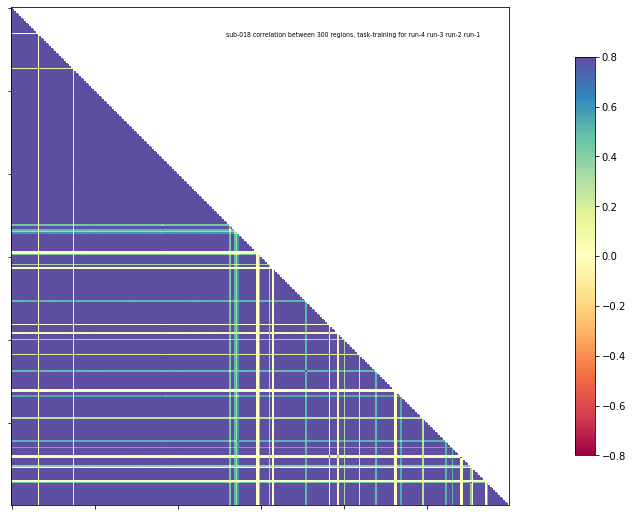


[INFO] sub-019 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.26


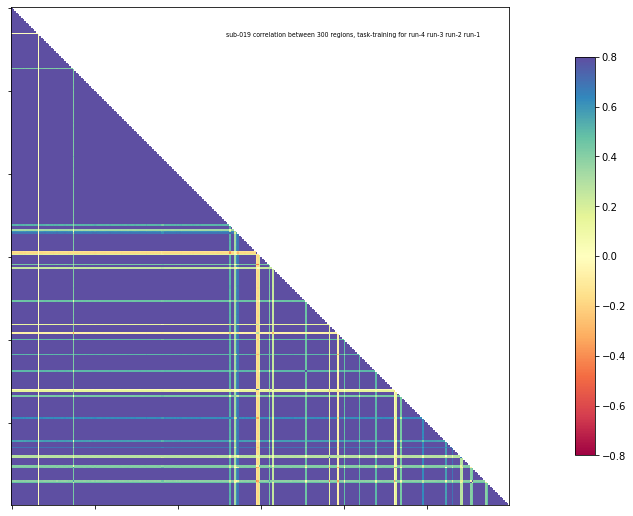


[INFO] sub-020 correlation between 300 regions, task-training for run-1 run-4 run-3 run-2  
[INFO] Mean: 0.87 	Std: 0.25


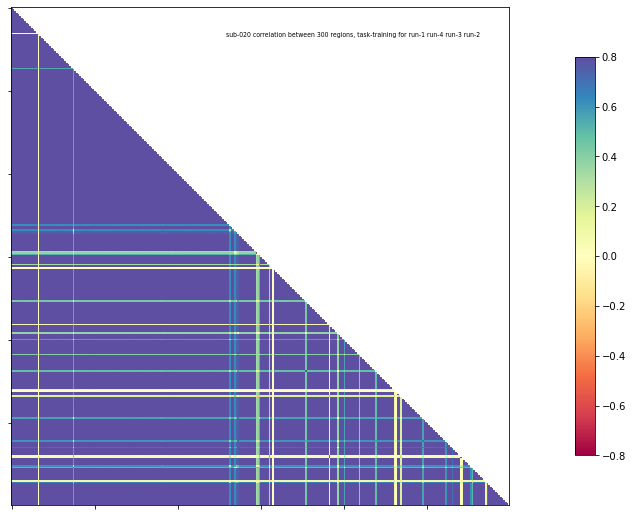


[INFO] sub-021 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


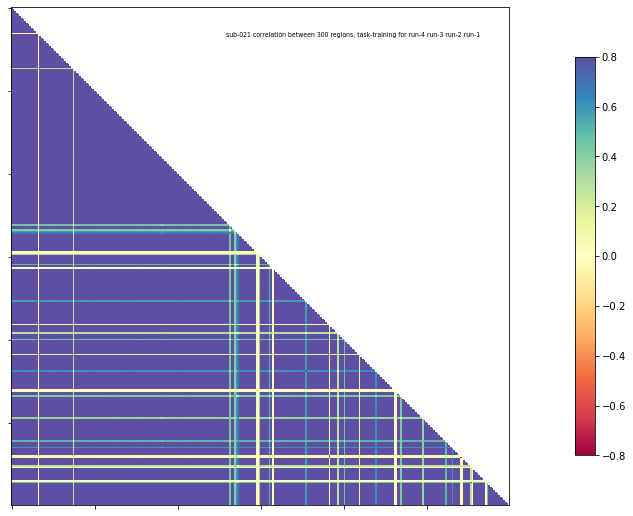


[INFO] sub-022 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


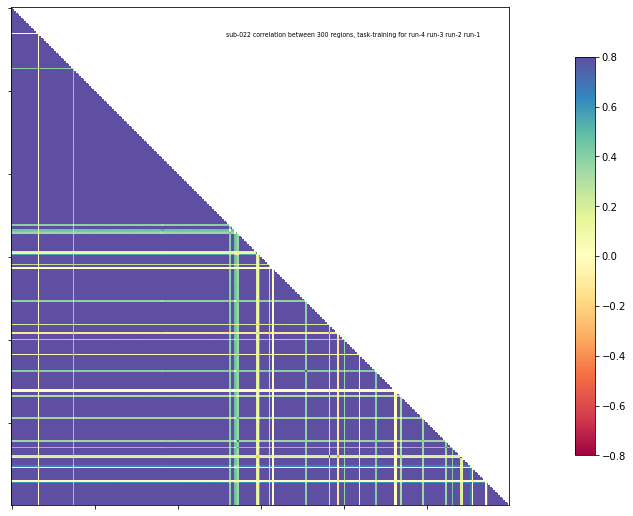


[INFO] sub-023 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


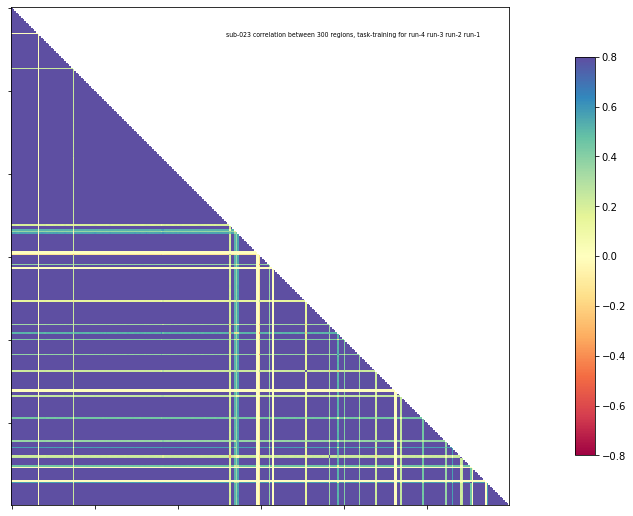


[INFO] sub-024 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.87 	Std: 0.27


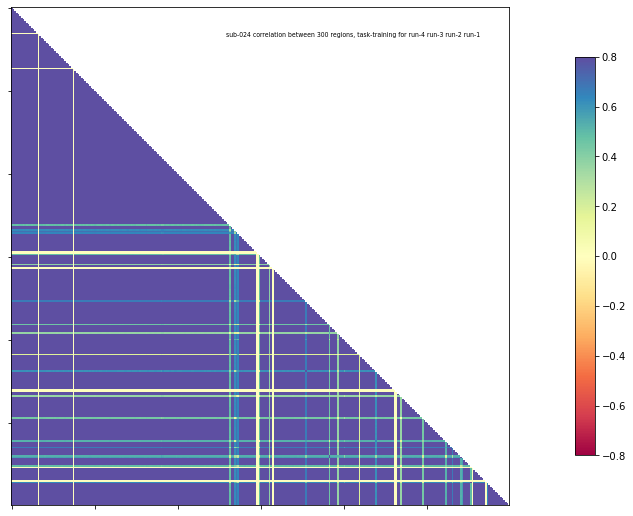


[INFO] sub-025 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.31


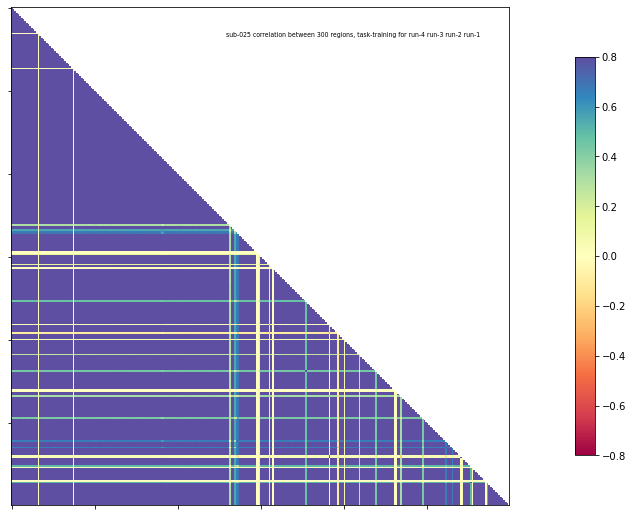


[INFO] sub-026 correlation between 300 regions, task-training for run-3 run-4 run-2 run-1  
[INFO] Mean: 0.83 	Std: 0.33


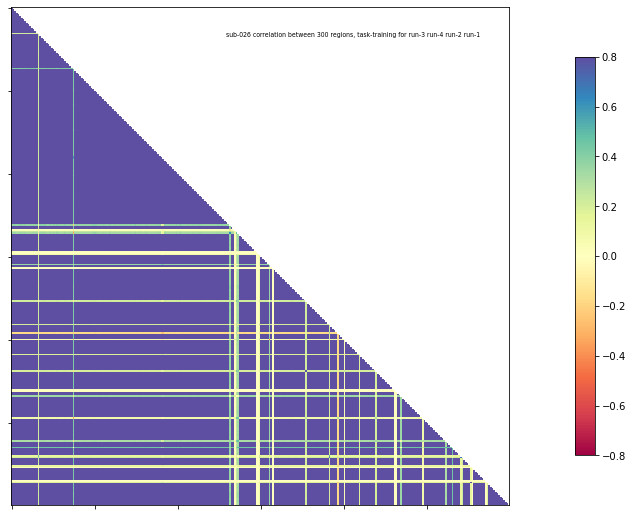


[INFO] sub-027 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.29


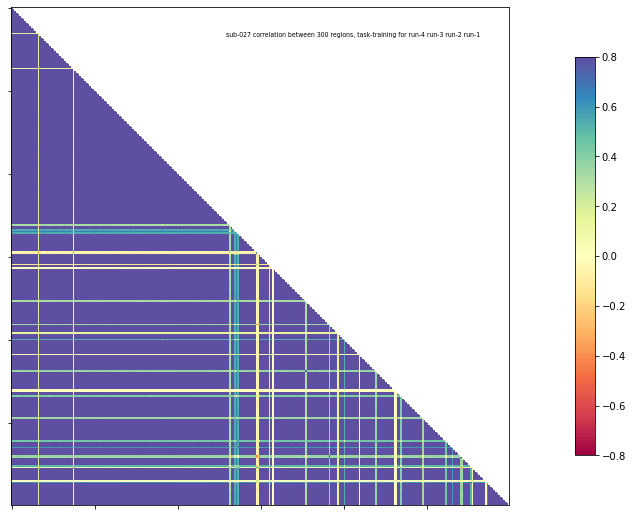


[INFO] sub-028 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.29


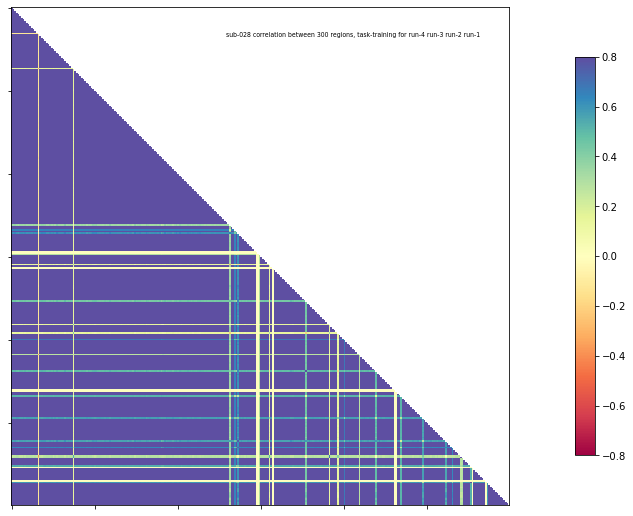


[INFO] sub-030 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


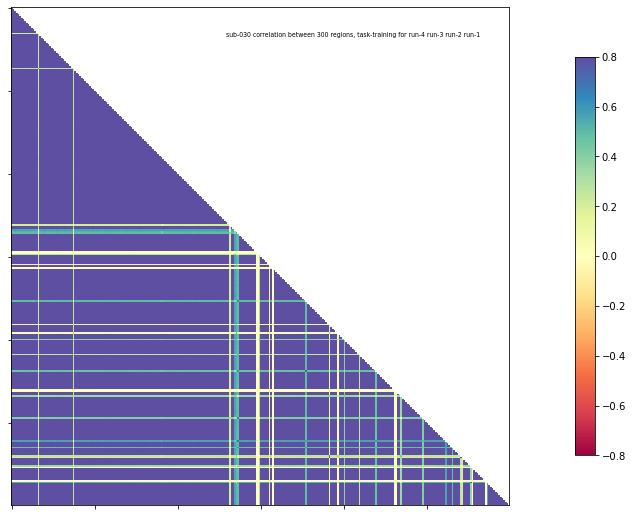


[INFO] sub-031 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.26


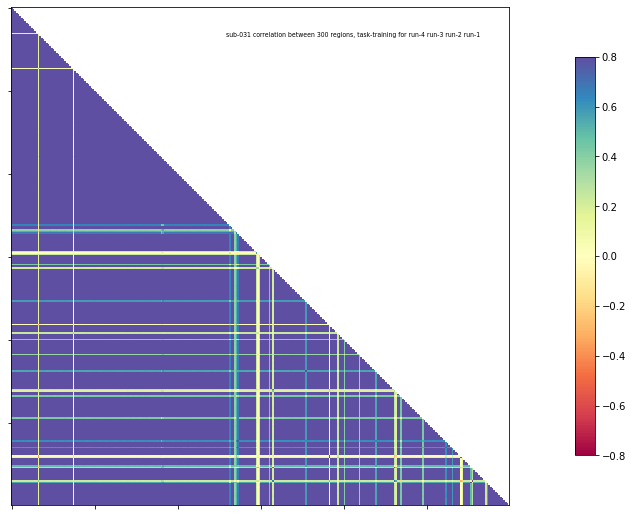


[INFO] sub-032 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


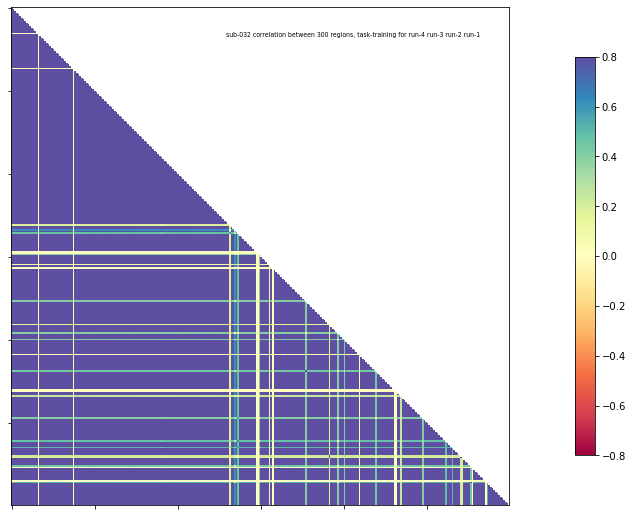


[INFO] sub-033 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.8 	Std: 0.3


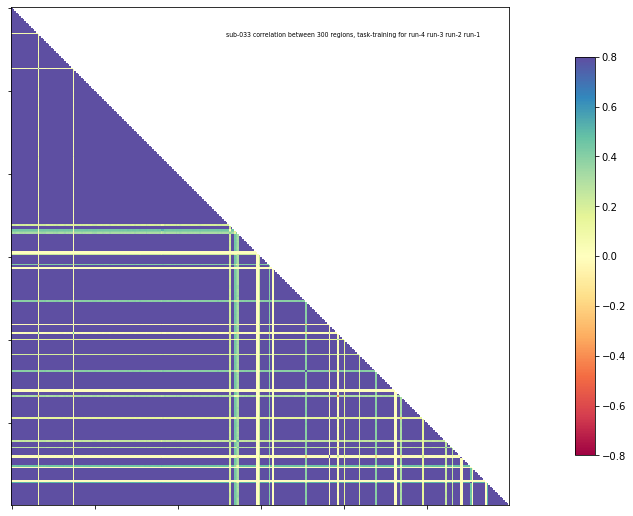


[INFO] sub-034 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.29


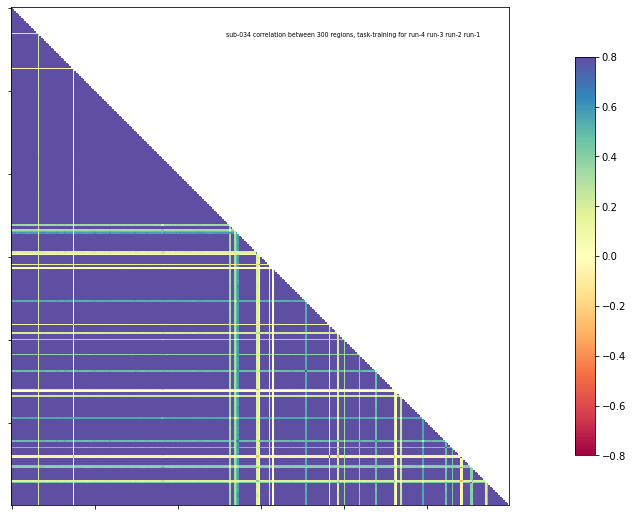


[INFO] sub-035 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.87 	Std: 0.26


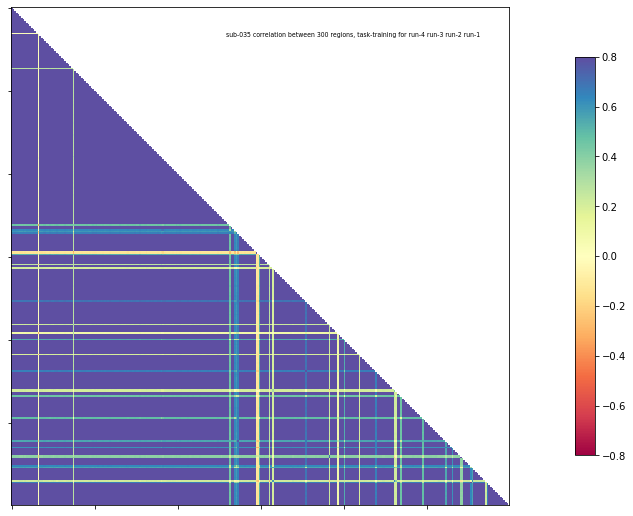


[INFO] sub-036 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.83 	Std: 0.3


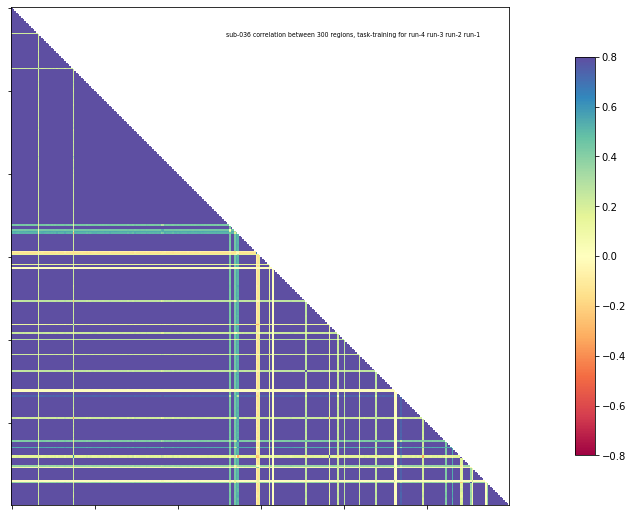


[INFO] sub-037 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.32


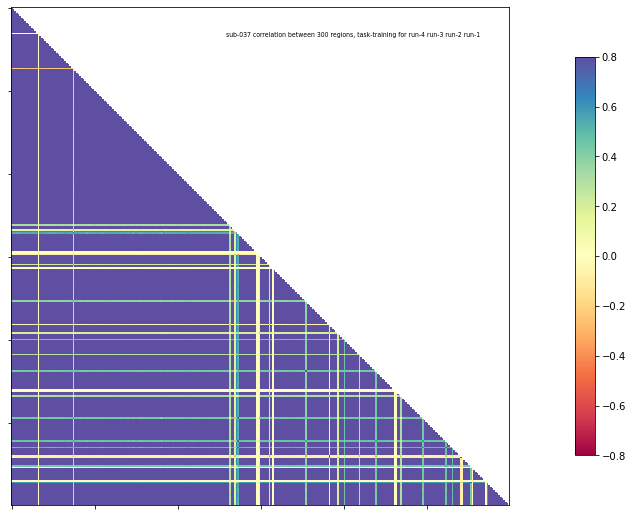


[INFO] sub-038 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.31


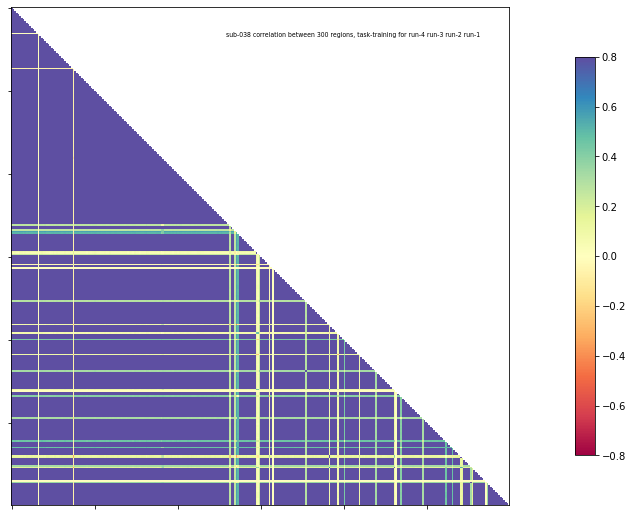


[INFO] sub-039 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.83 	Std: 0.29


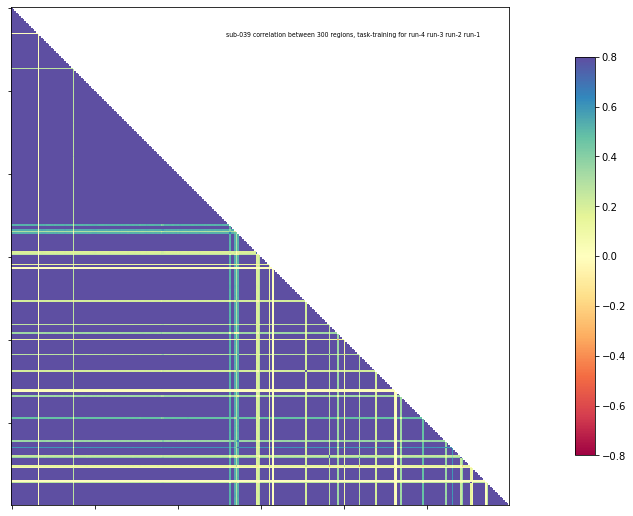


[INFO] sub-040 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.83 	Std: 0.3


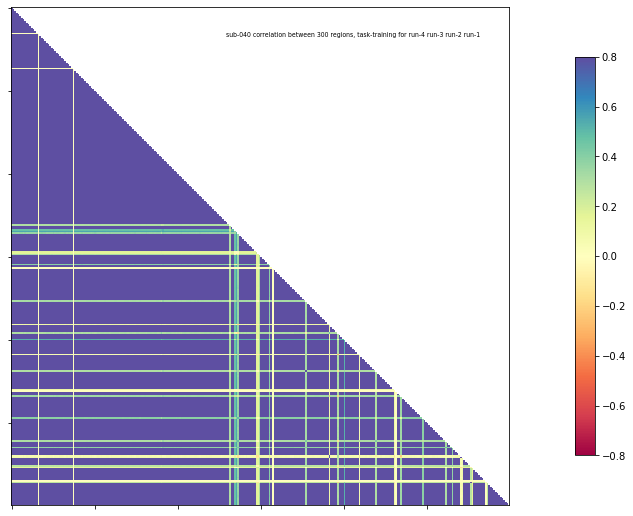


[INFO] sub-041 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.3


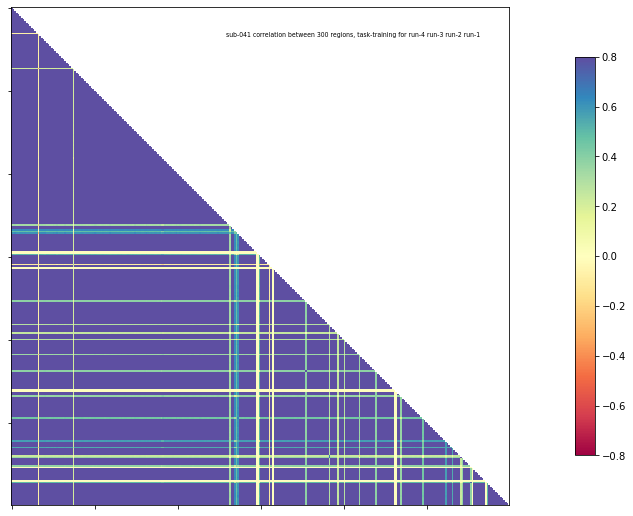


[INFO] sub-043 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.87 	Std: 0.26


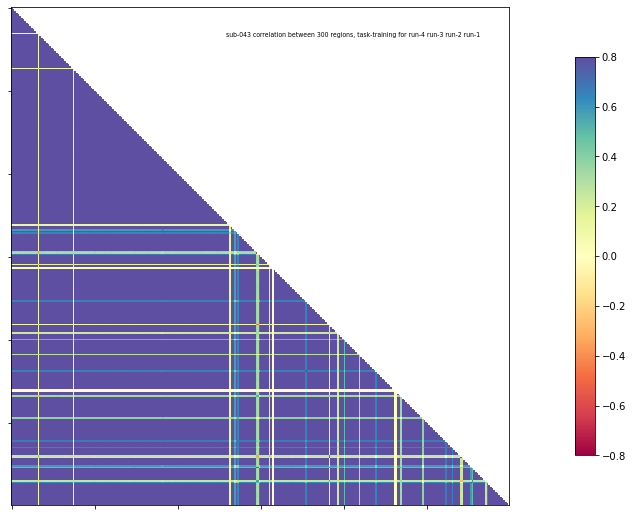


[INFO] sub-044 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.3


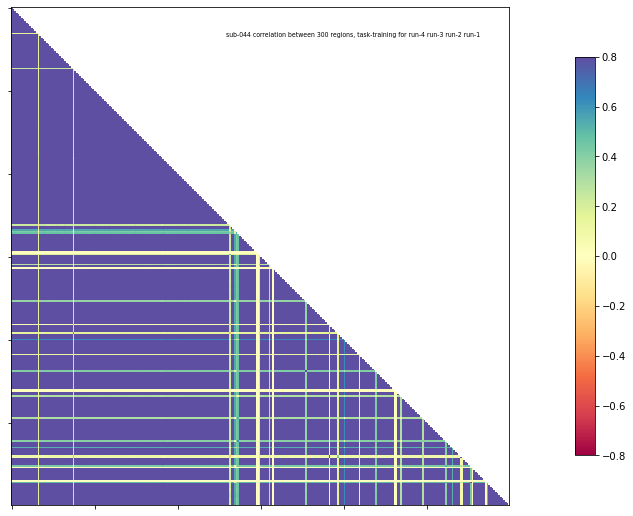


[INFO] sub-045 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.81 	Std: 0.27


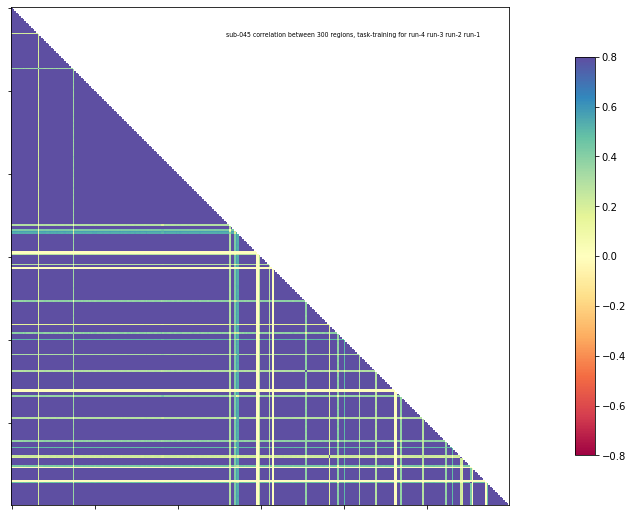


[INFO] sub-046 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.77 	Std: 0.27


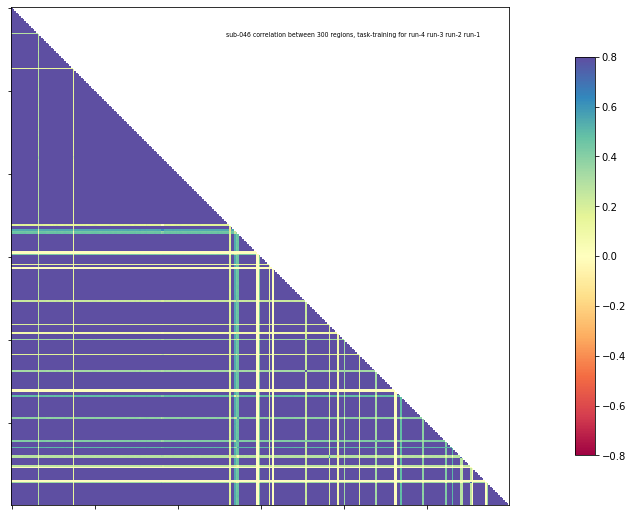


[INFO] sub-048 correlation between 300 regions, task-training for run-3 run-2 run-1  
[INFO] Mean: 0.83 	Std: 0.31


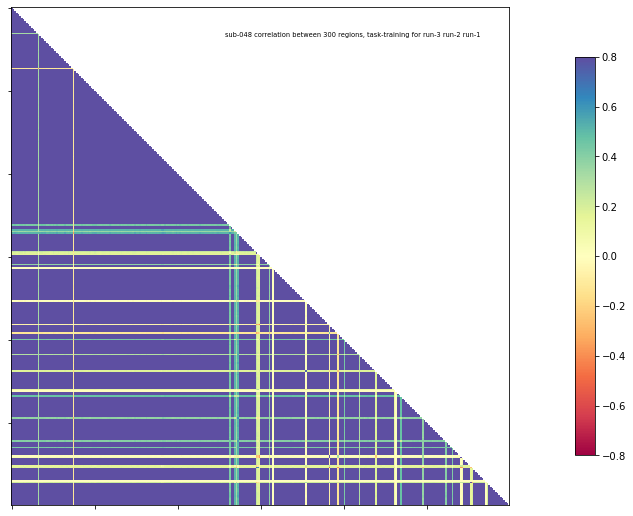


[INFO] sub-050 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.87 	Std: 0.28


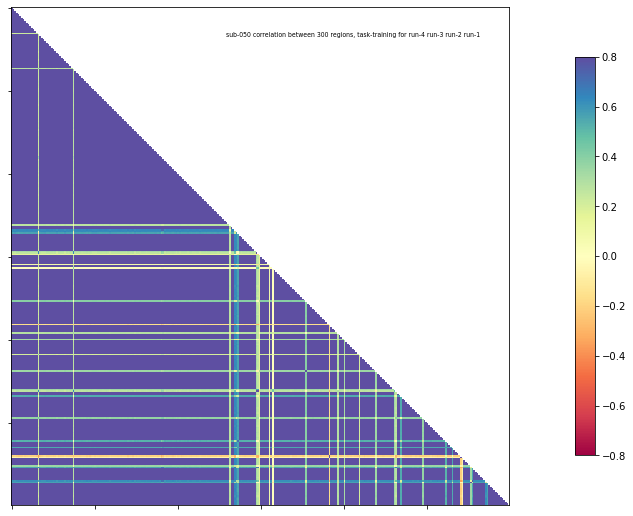


[INFO] sub-051 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.29


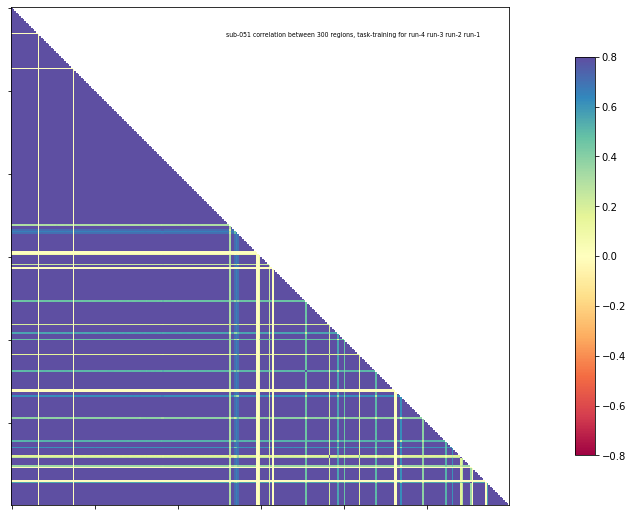


[INFO] sub-053 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.82 	Std: 0.31


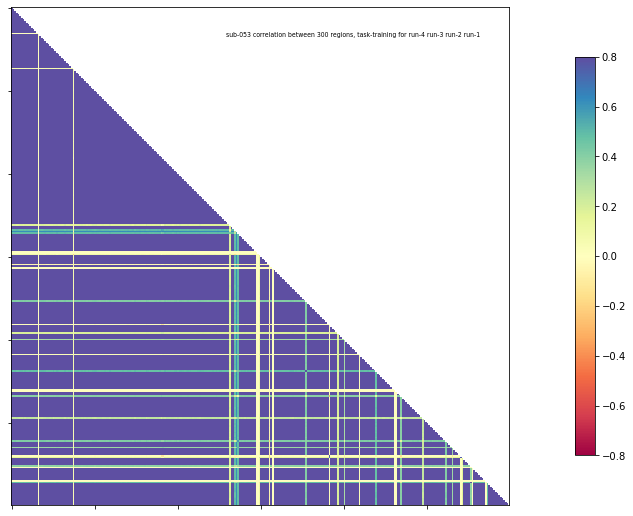


[INFO] sub-054 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.33


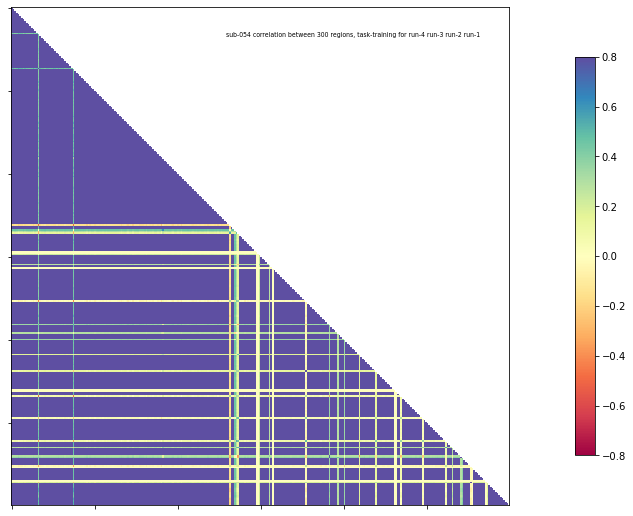


[INFO] sub-055 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.29


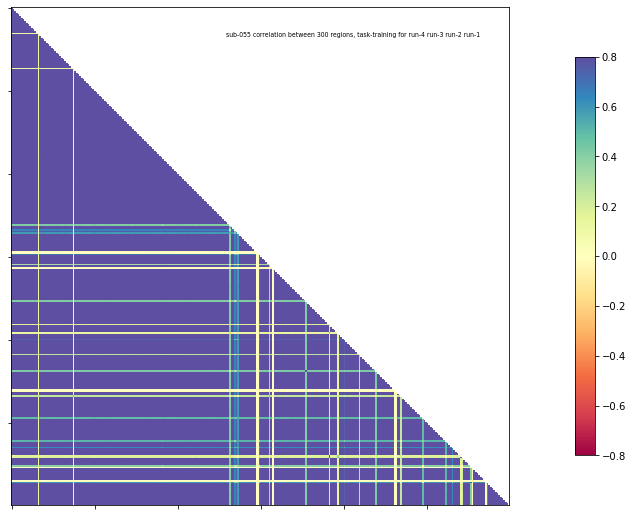


[INFO] sub-056 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.32


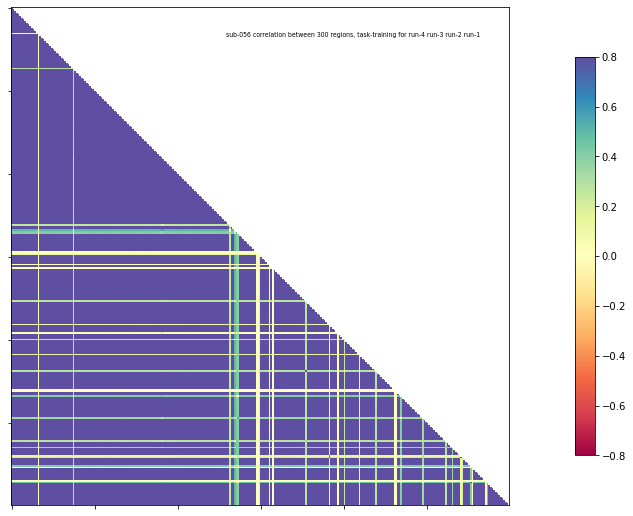


[INFO] sub-057 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.87 	Std: 0.26


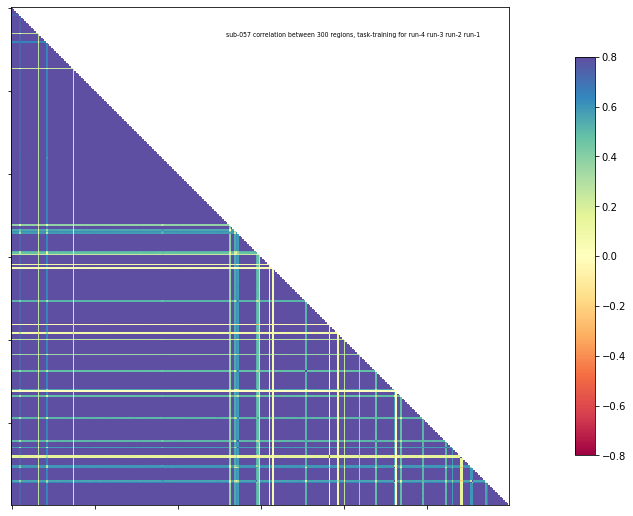


[INFO] sub-058 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.31


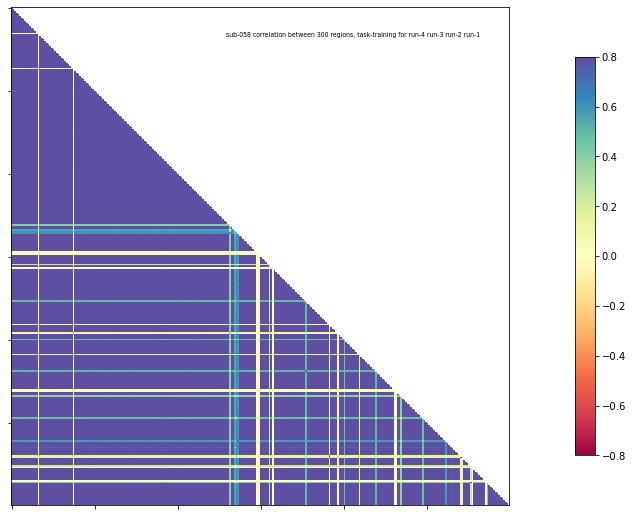


[INFO] sub-059 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.28


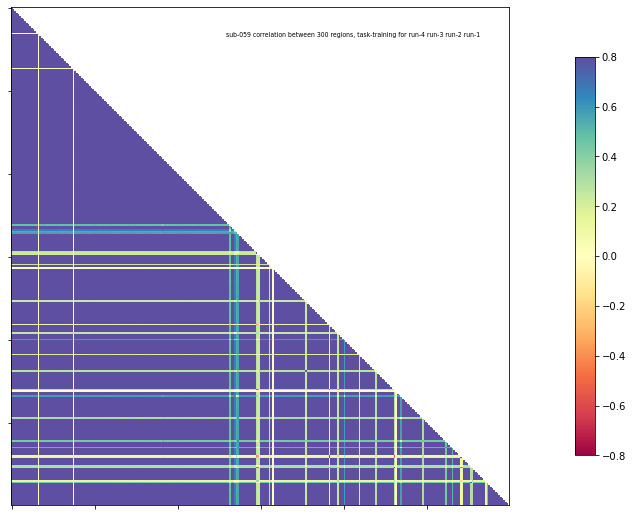


[INFO] sub-060 correlation between 300 regions, task-training for run-2 run-1 
[INFO] Mean: 0.85 	Std: 0.3


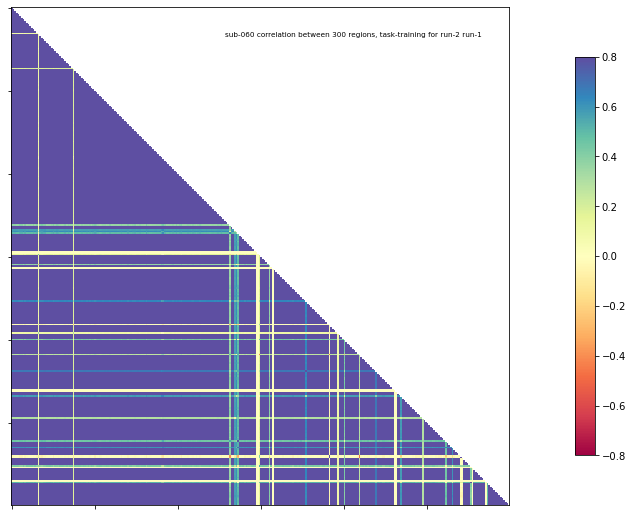


[INFO] sub-061 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


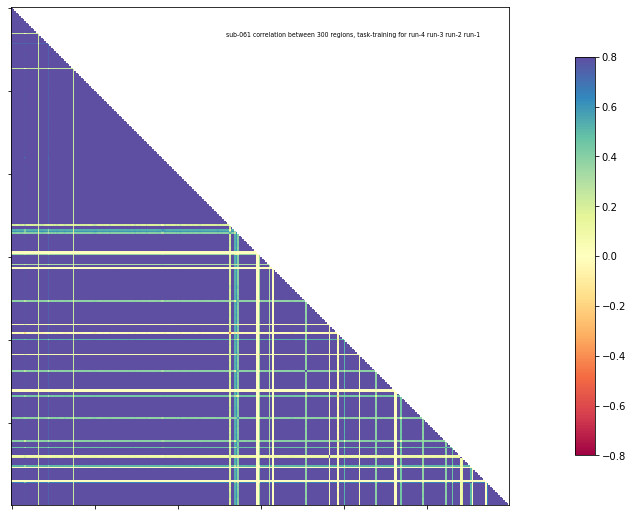


[INFO] sub-062 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.29


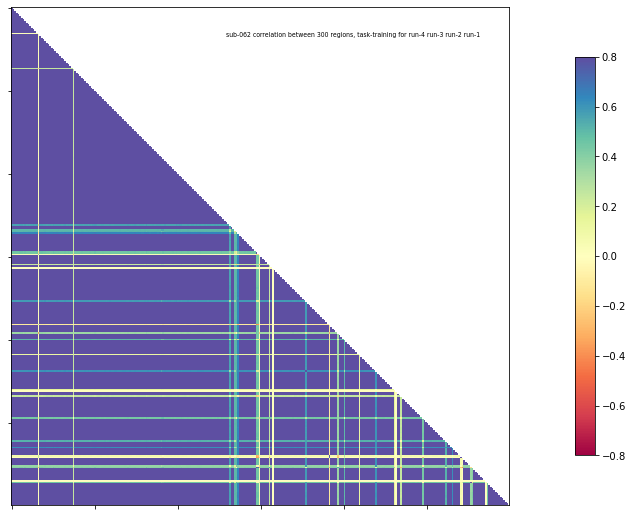


[INFO] sub-063 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.87 	Std: 0.28


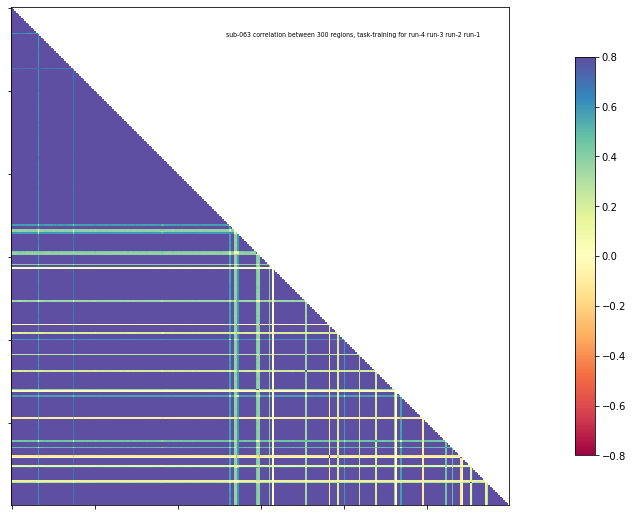


[INFO] sub-064 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.3


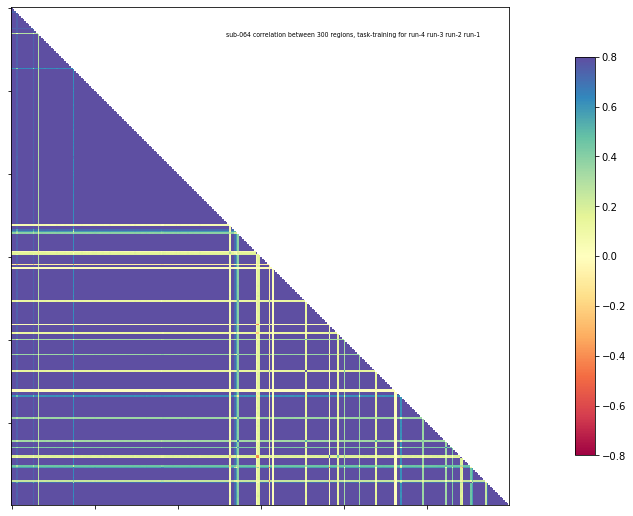


[INFO] sub-065 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.27


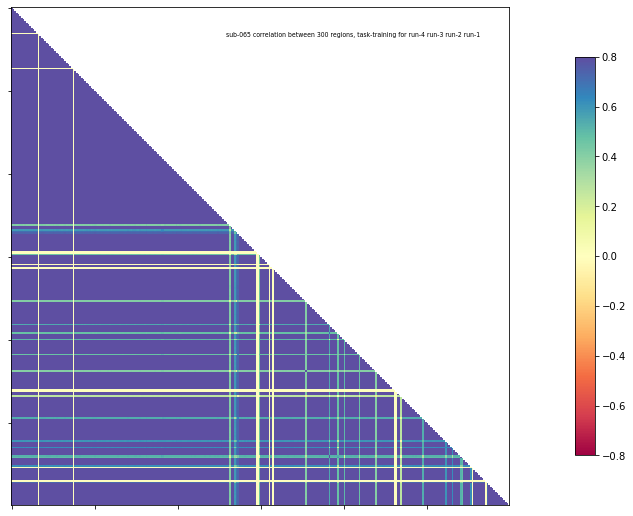


[INFO] sub-066 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.87 	Std: 0.28


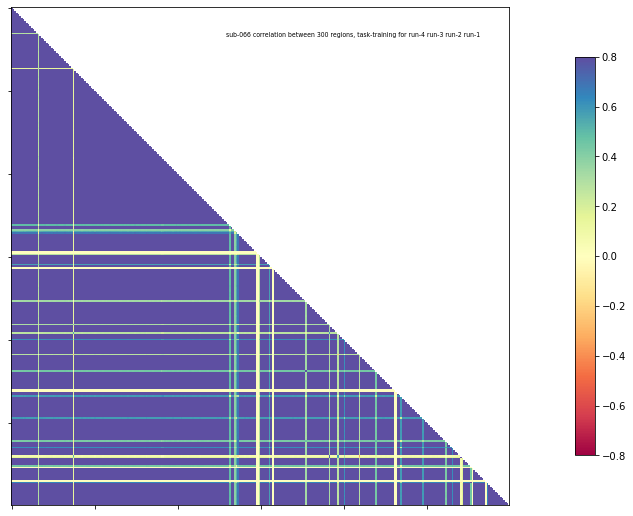


[INFO] sub-067 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.28


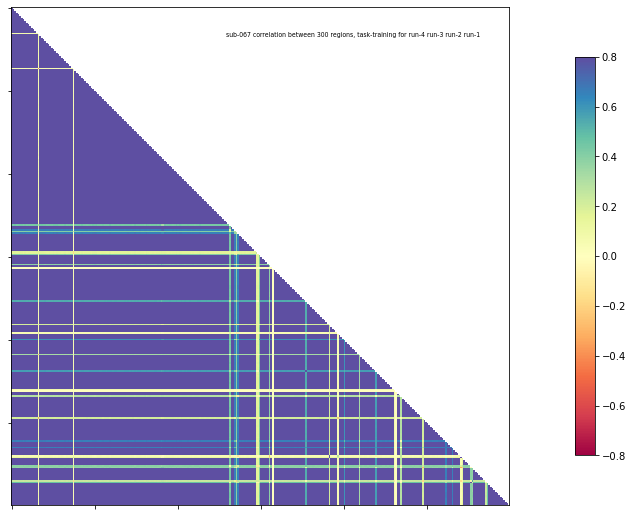


[INFO] sub-068 correlation between 300 regions, task-training for run-3 run-4 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.31


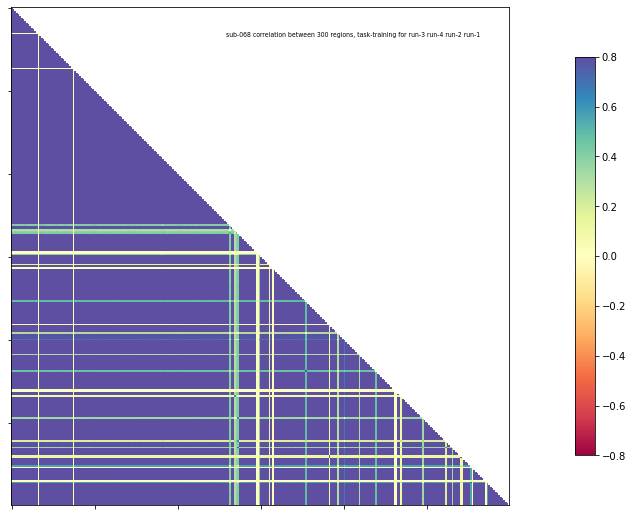


[INFO] sub-070 correlation between 300 regions, task-training for run-2 run-3 run-1  
[INFO] Mean: 0.79 	Std: 0.26


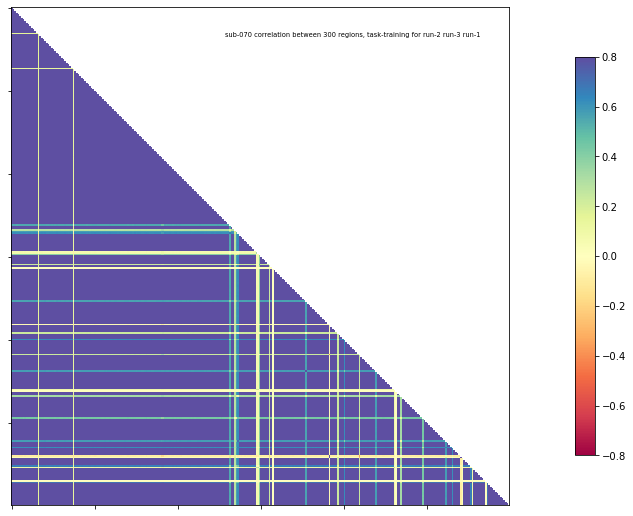


[INFO] sub-071 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.31


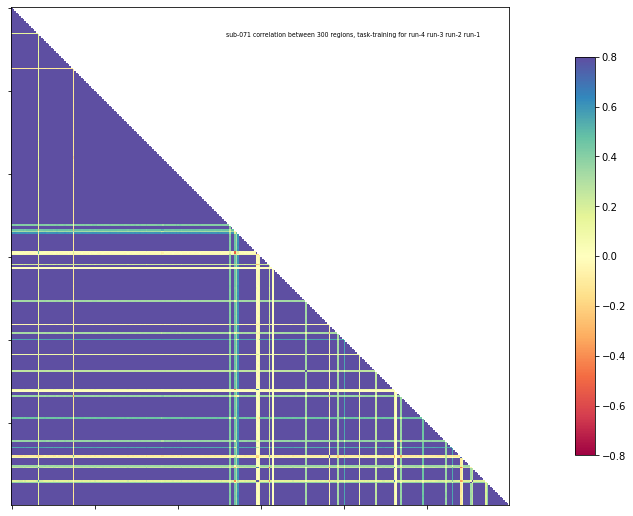


[INFO] sub-072 correlation between 300 regions, task-training for run-3 run-4 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.28


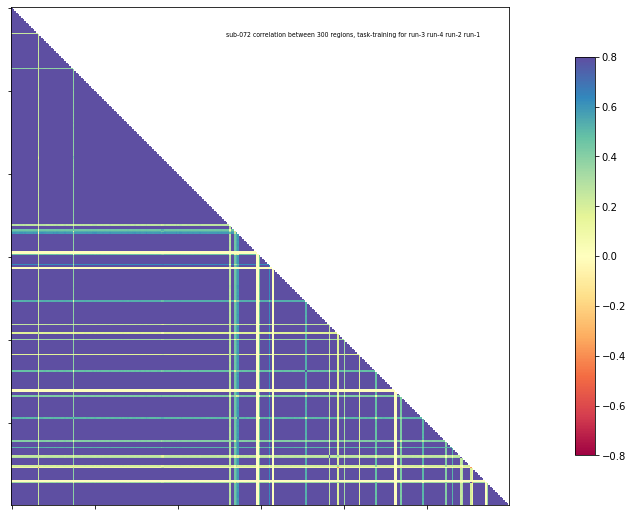


[INFO] sub-075 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.82 	Std: 0.26


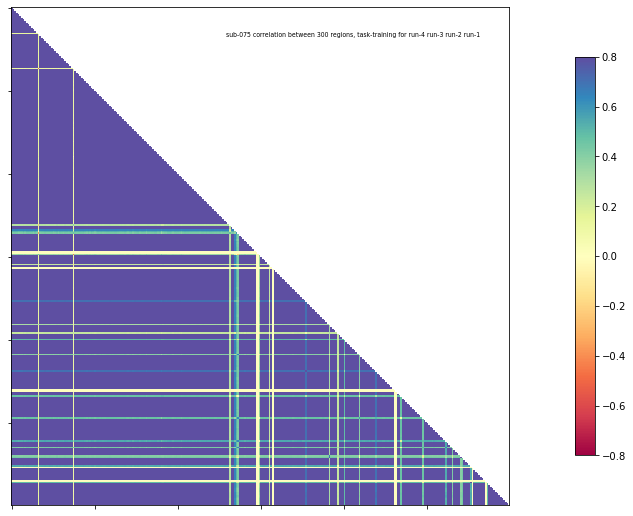


[INFO] sub-076 correlation between 300 regions, task-training for run-3 run-2 run-1 
[INFO] Mean: 0.87 	Std: 0.27


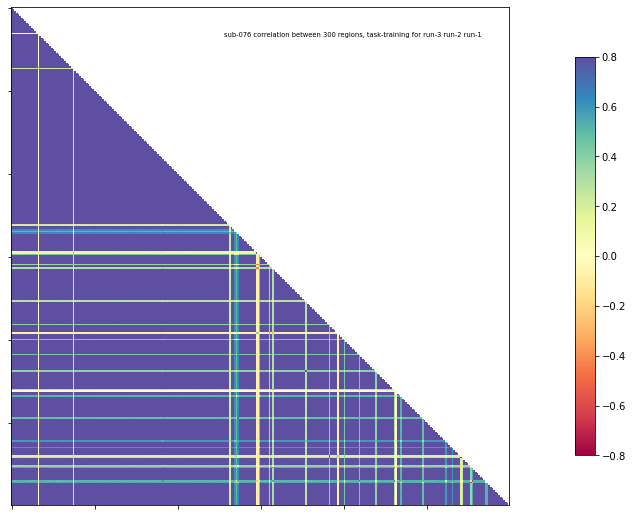


[INFO] sub-078 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.29


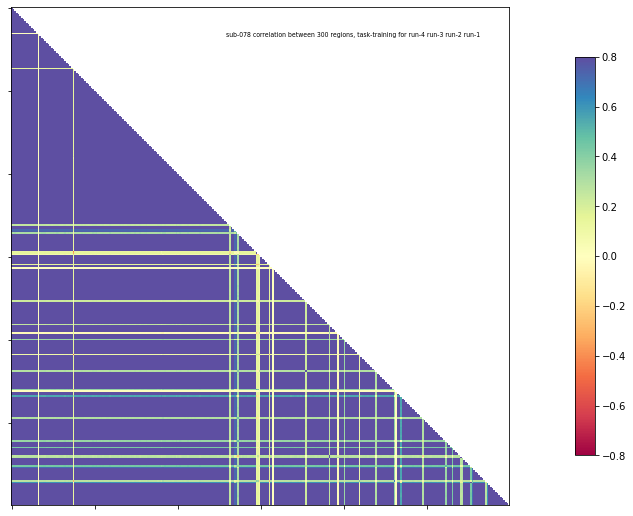


[INFO] sub-079 correlation between 300 regions, task-training for run-3 run-4 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


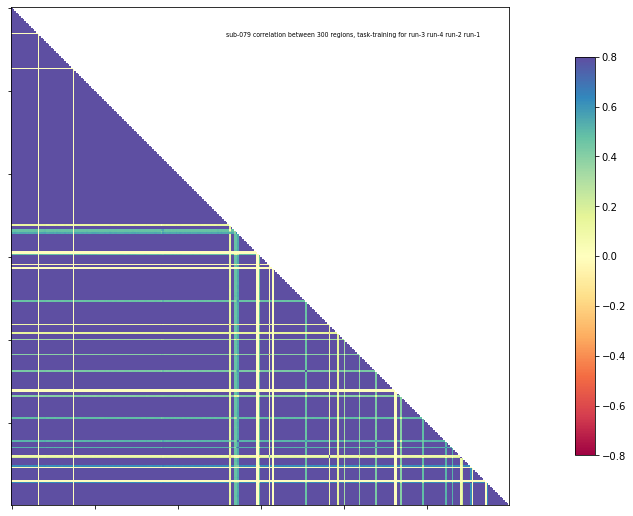


[INFO] sub-080 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.32


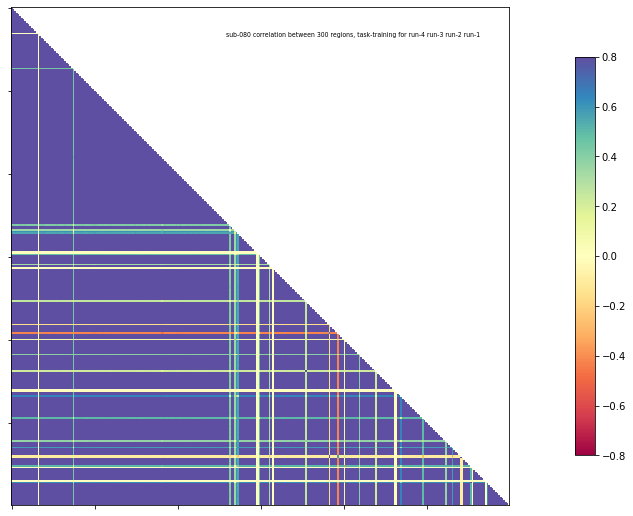


[INFO] sub-082 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.28


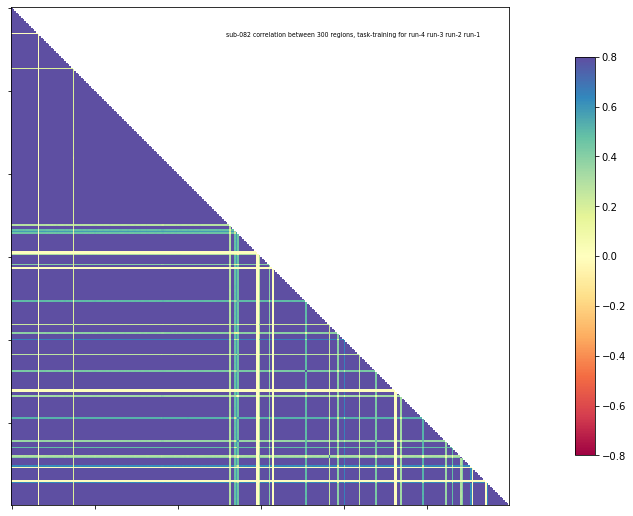


[INFO] sub-083 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.32


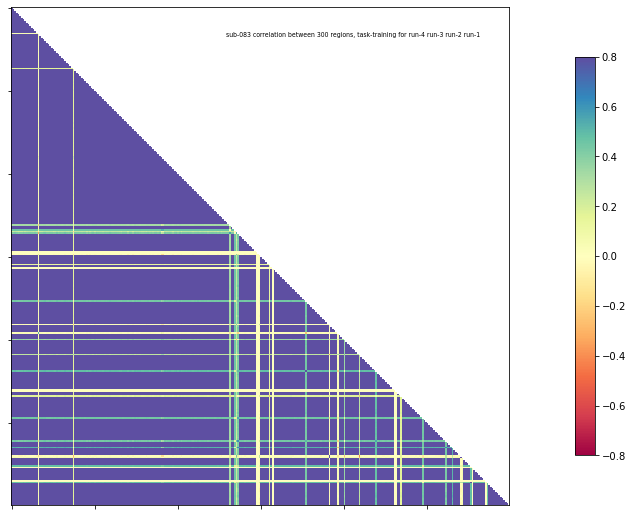


[INFO] sub-084 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


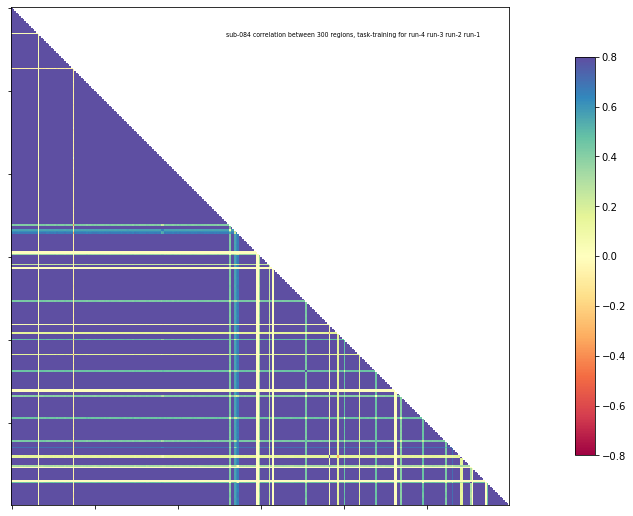


[INFO] sub-085 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


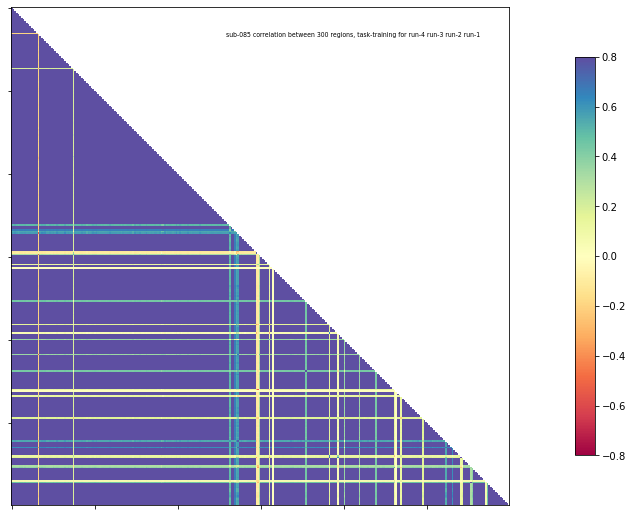


[INFO] sub-086 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.29


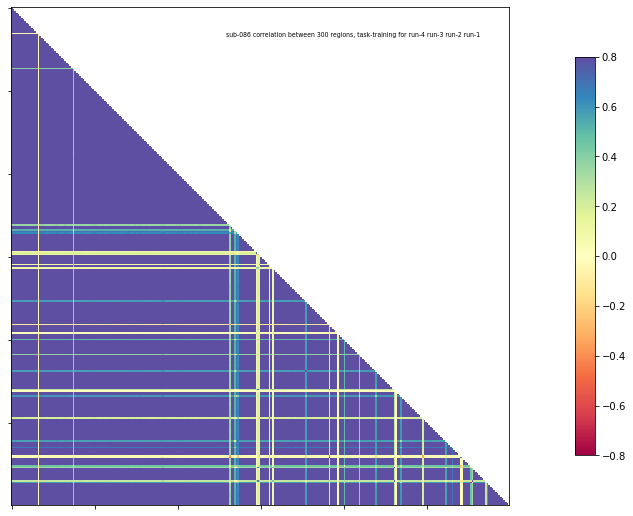


[INFO] sub-087 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.29


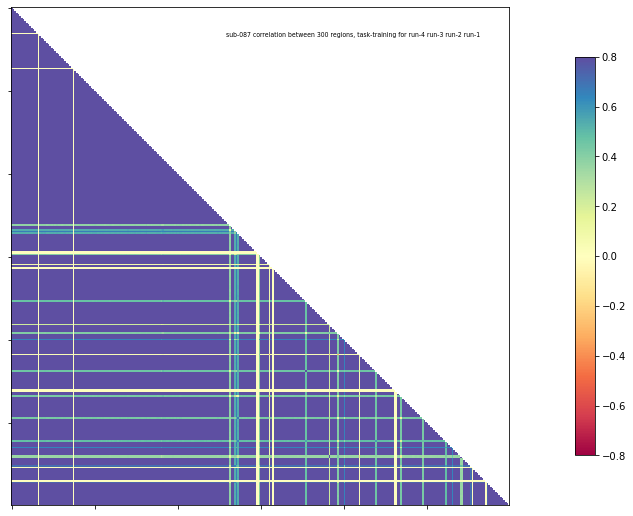


[INFO] sub-088 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.28


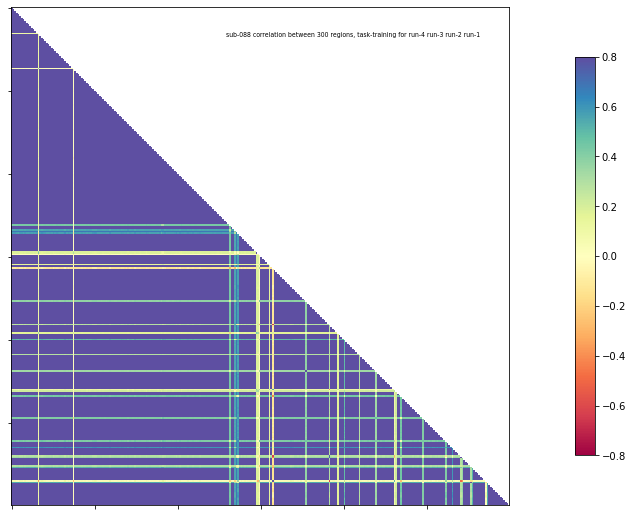


[INFO] sub-089 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.83 	Std: 0.28


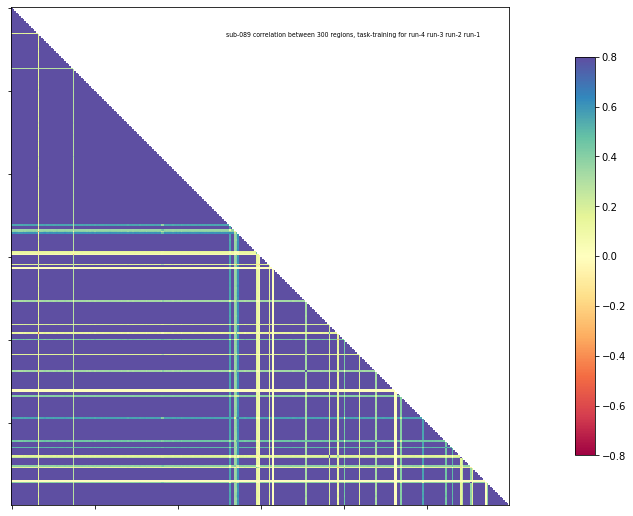


[INFO] sub-090 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


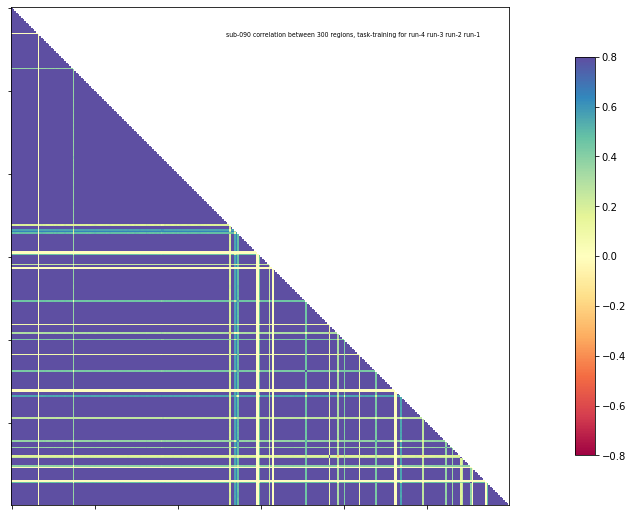


[INFO] sub-091 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.78 	Std: 0.25


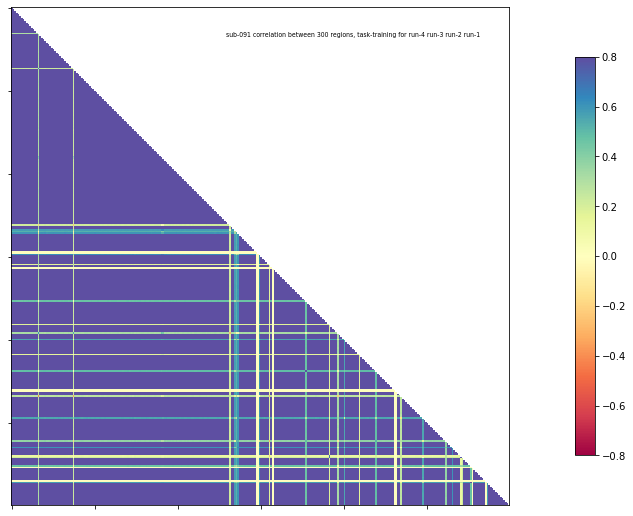


[INFO] sub-092 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.31


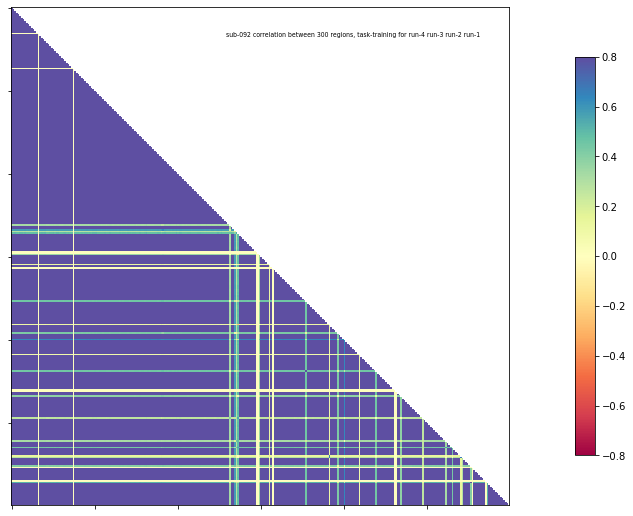


[INFO] sub-093 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.32


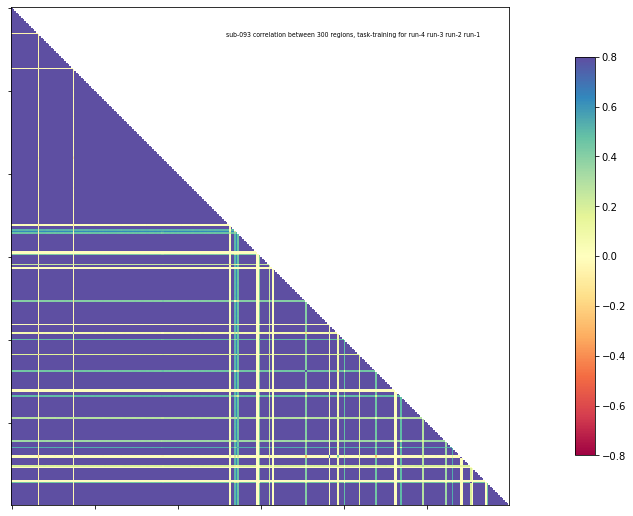


[INFO] sub-095 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.3


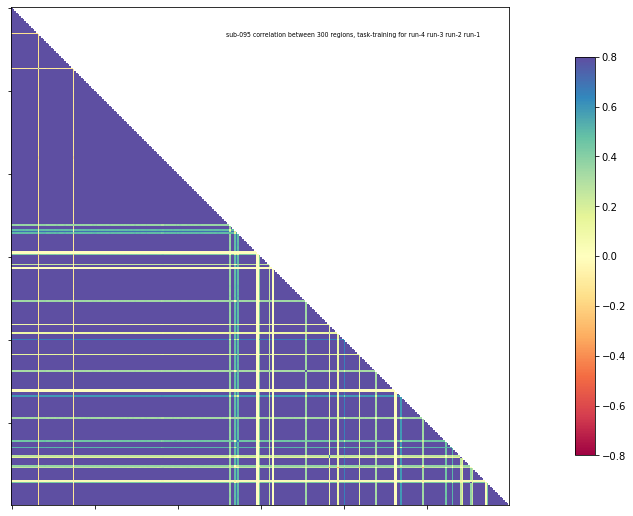


[INFO] sub-096 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.29


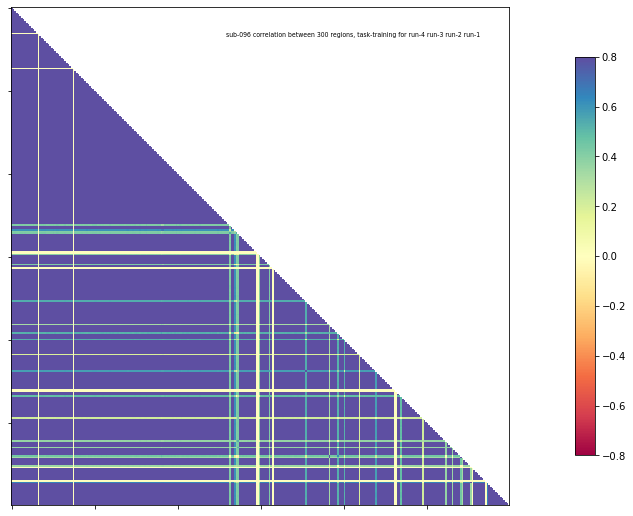


[INFO] sub-097 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.3


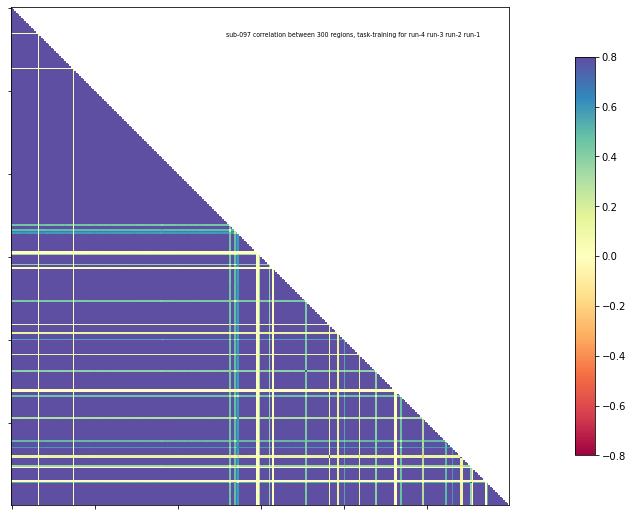


[INFO] sub-098 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.88 	Std: 0.26


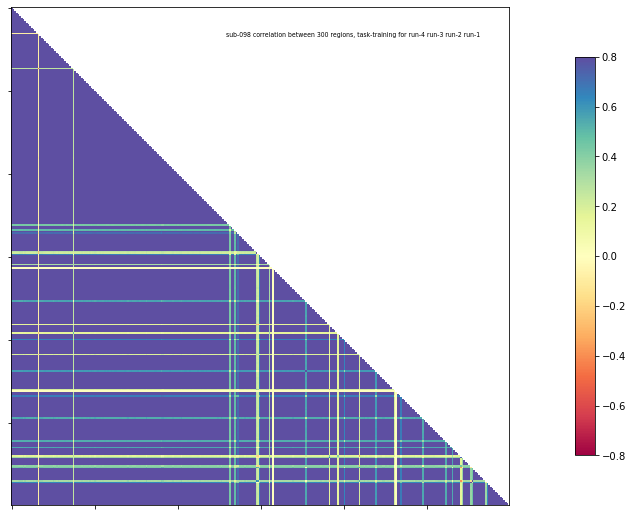


[INFO] sub-099 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


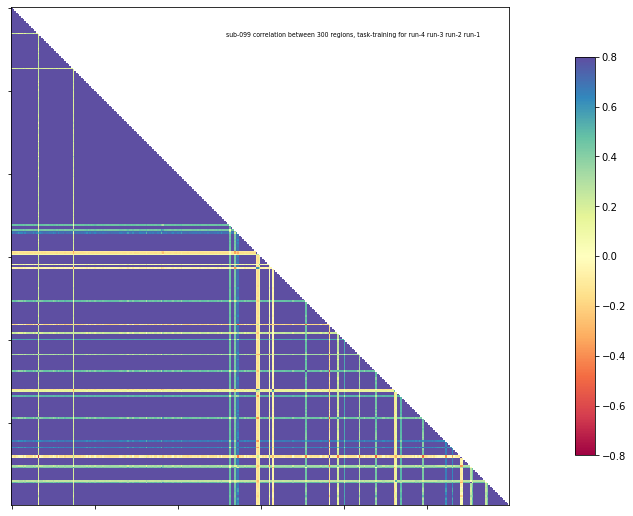


[INFO] sub-100 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.31


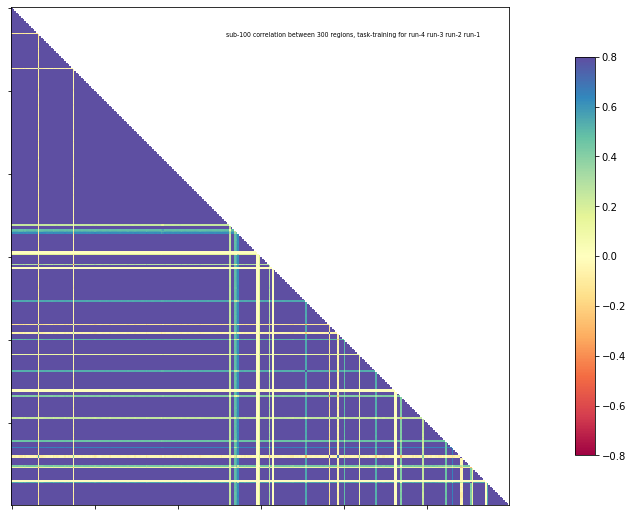


[INFO] sub-102 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.83 	Std: 0.31


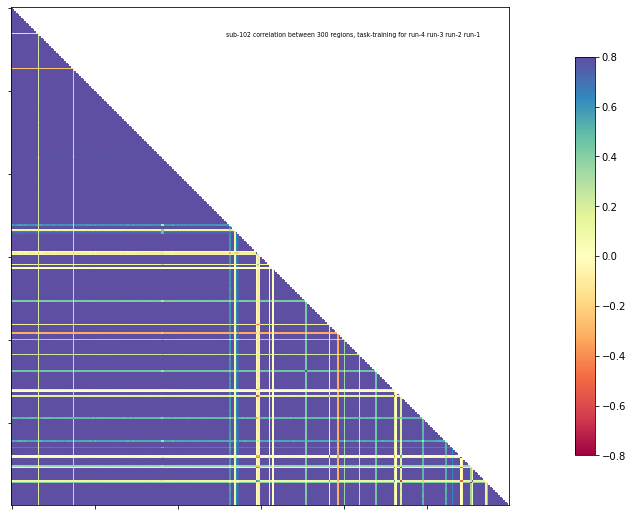


[INFO] sub-103 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


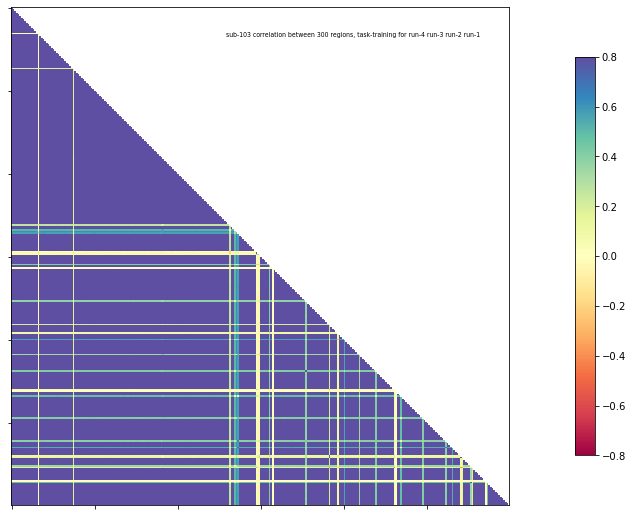


[INFO] sub-104 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.3


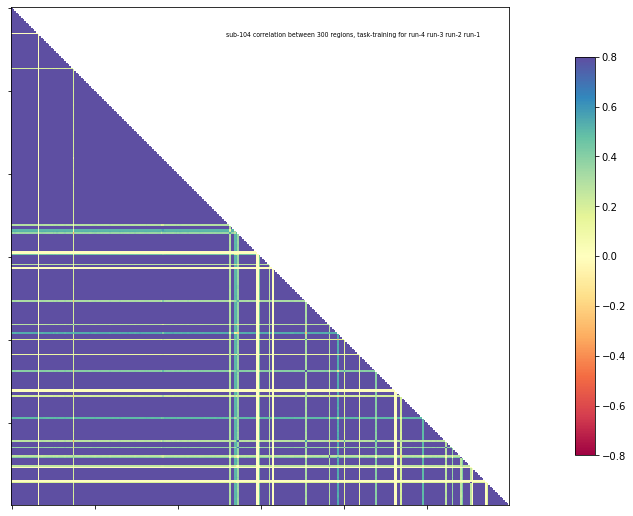


[INFO] sub-107 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.31


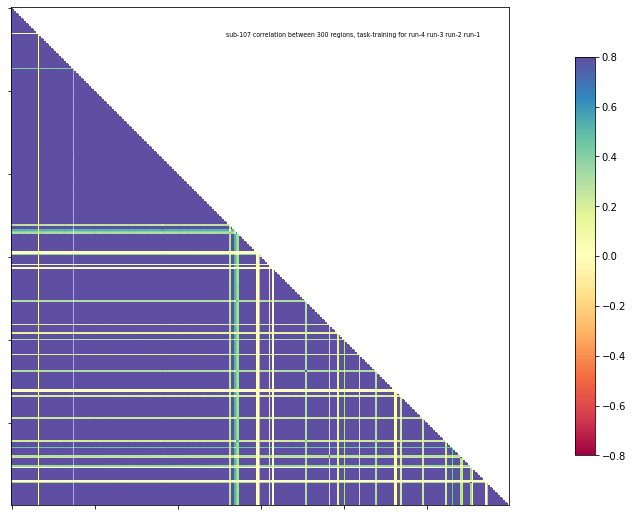


[INFO] sub-108 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.26


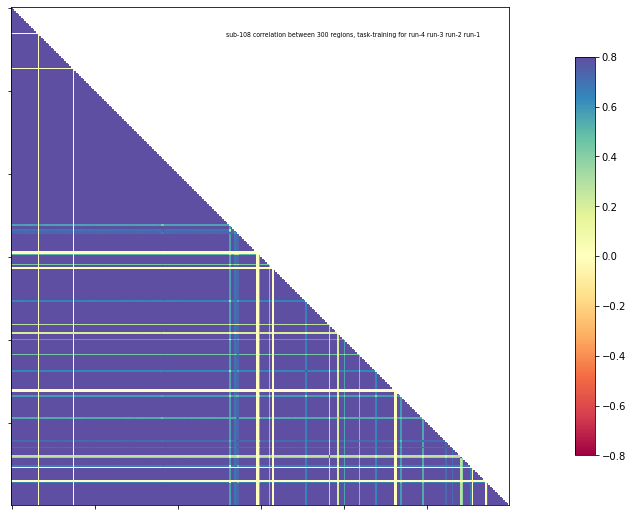


[INFO] sub-109 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.3


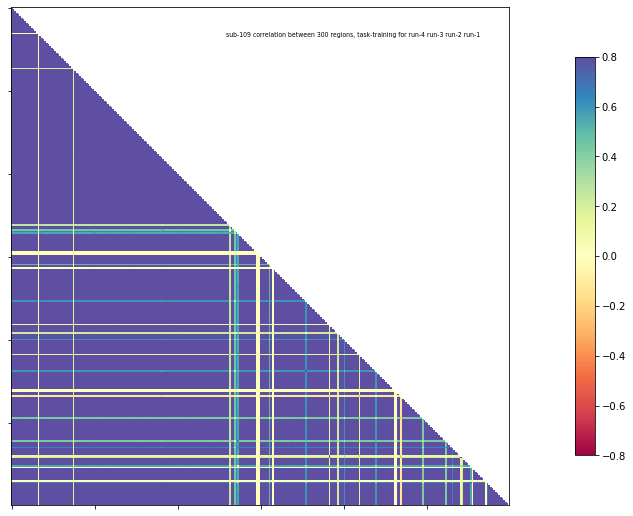


[INFO] sub-111 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.31


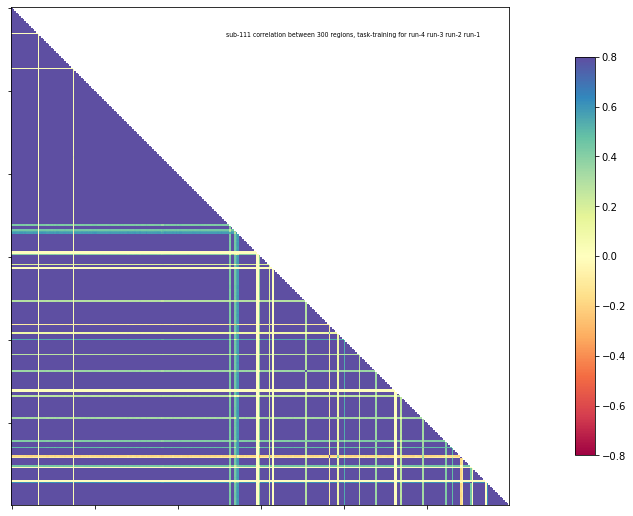


[INFO] sub-112 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


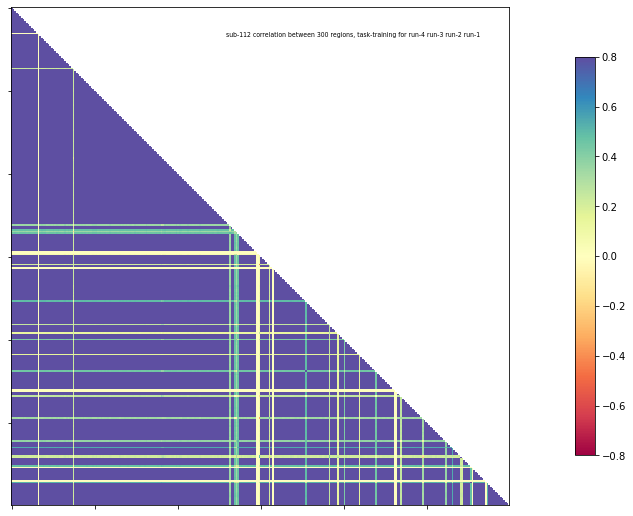


[INFO] sub-114 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.31


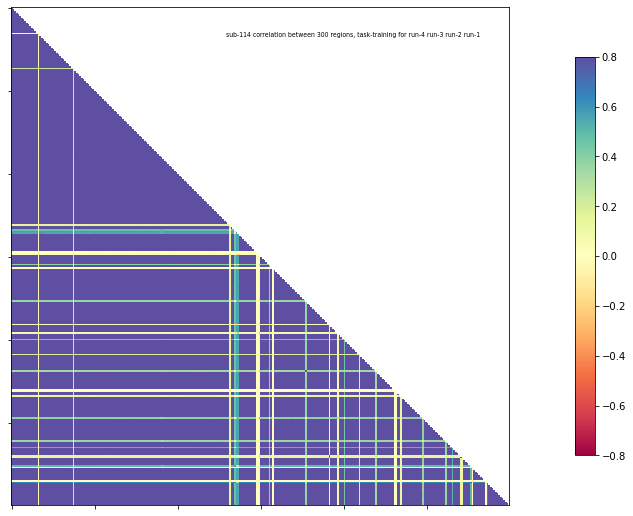


[INFO] sub-115 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.82 	Std: 0.29


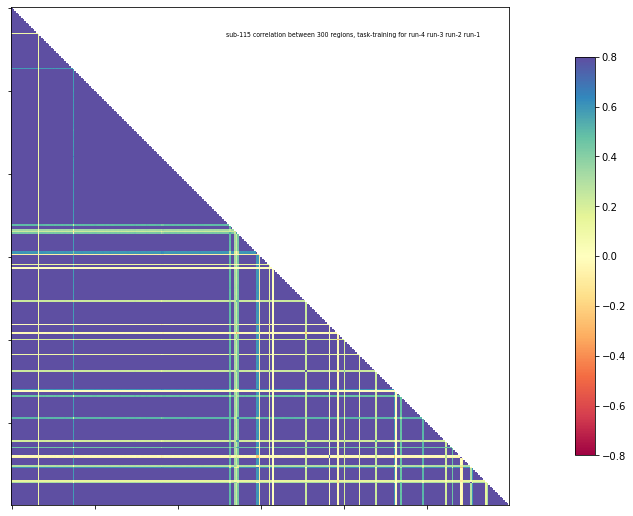


[INFO] sub-116 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.29


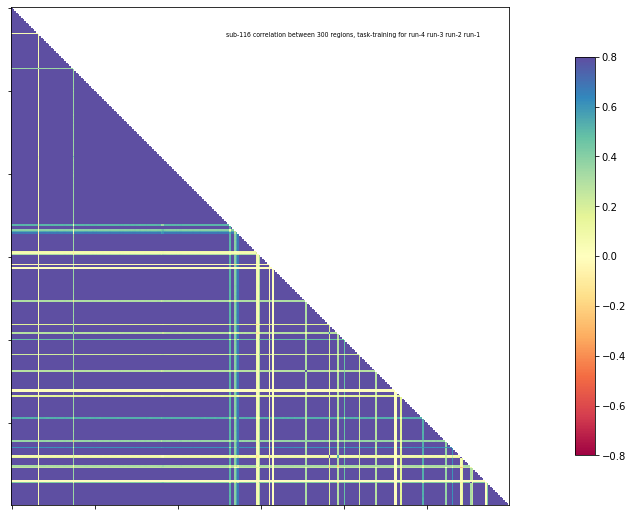


[INFO] sub-117 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.3


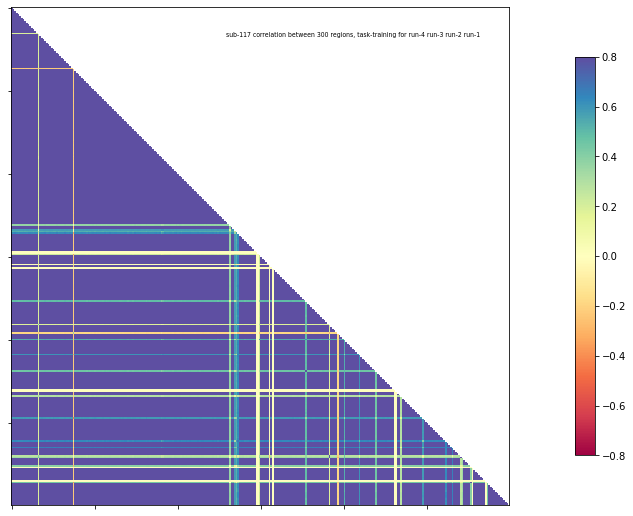


[INFO] sub-118 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.31


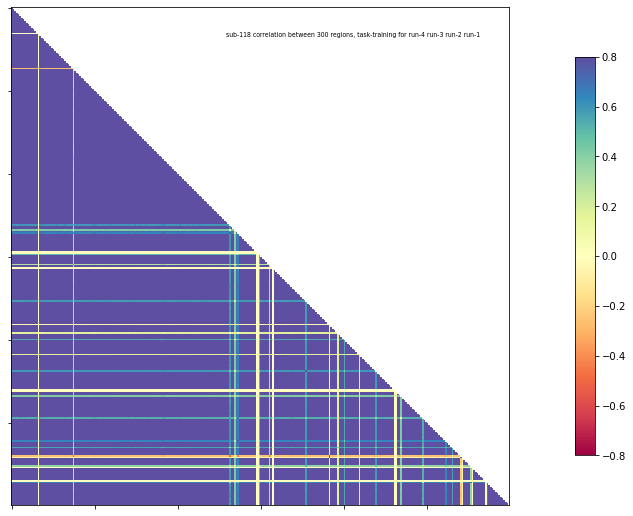


[INFO] sub-119 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.83 	Std: 0.28


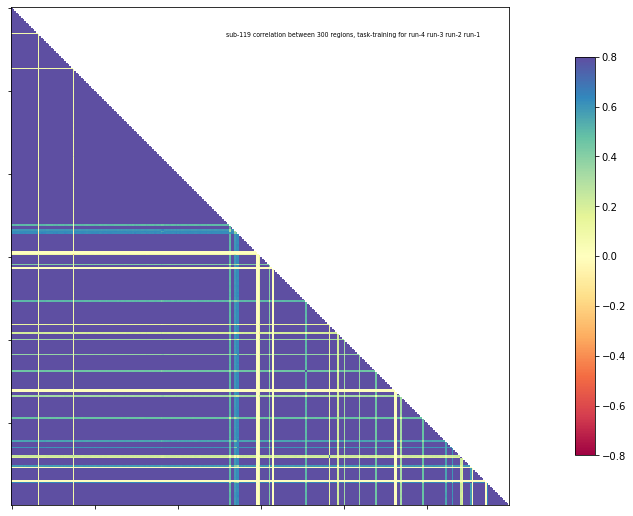


[INFO] sub-120 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.29


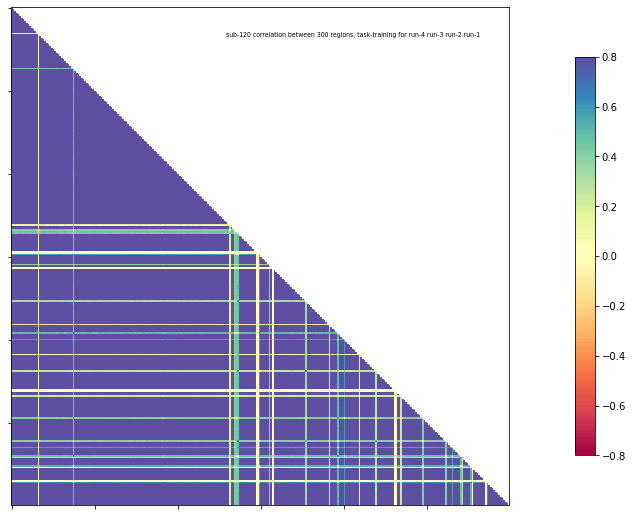


[INFO] sub-121 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.83 	Std: 0.25


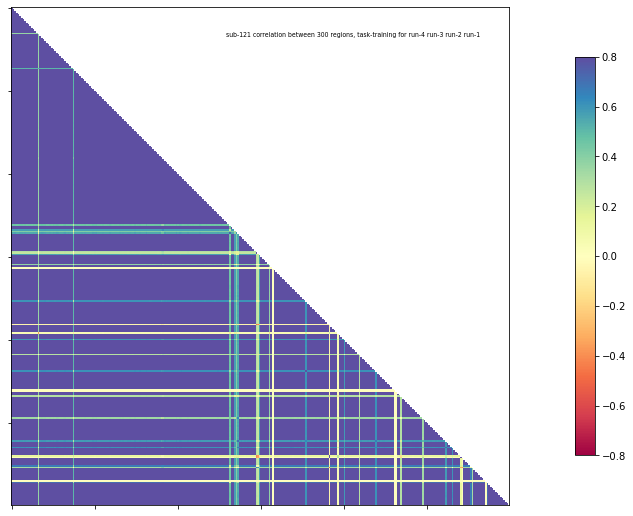


[INFO] sub-123 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.82 	Std: 0.3


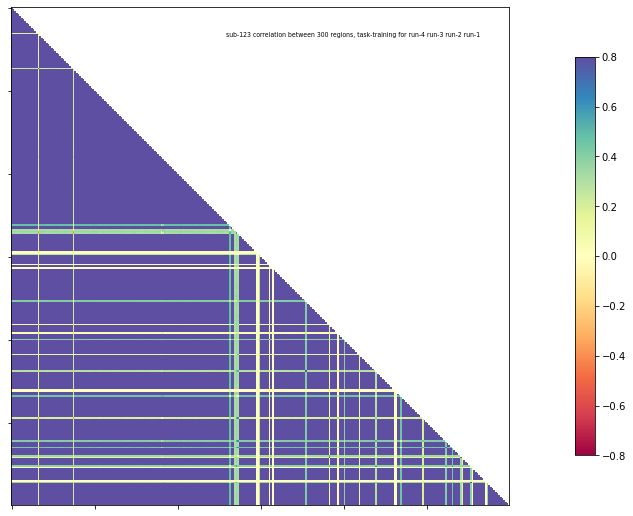


[INFO] sub-124 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


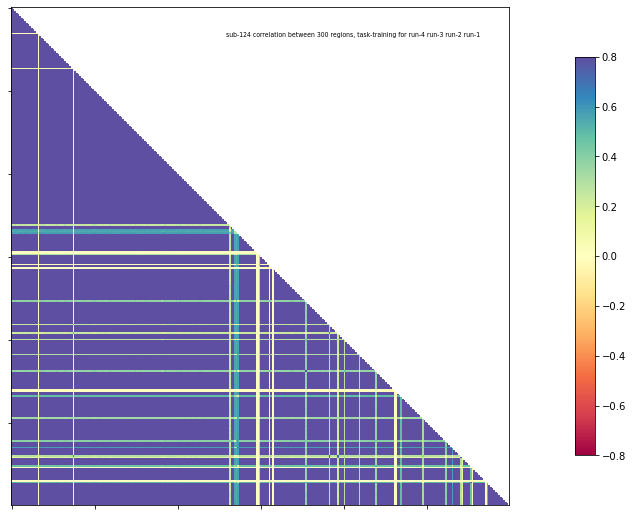


[INFO] sub-127 correlation between 300 regions, task-training for run-3 run-4 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.27


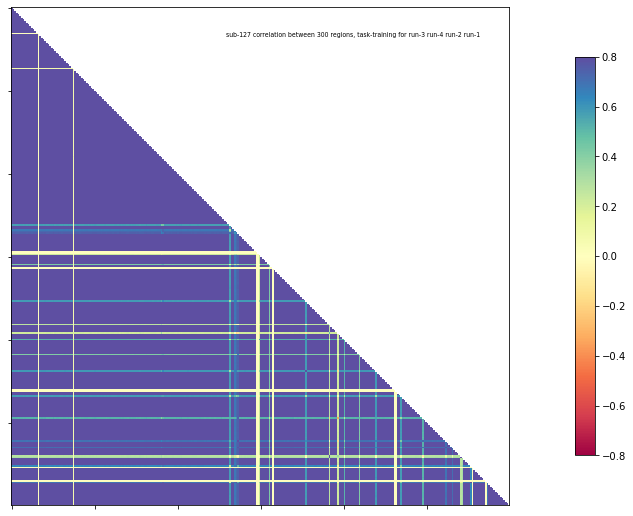


[INFO] sub-129 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.83 	Std: 0.31


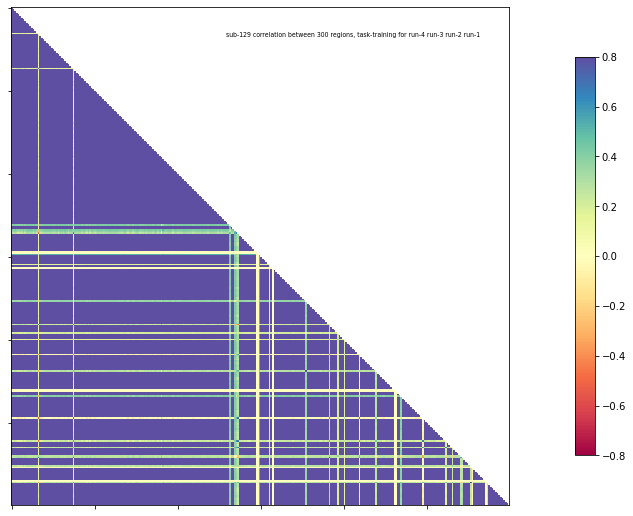


[INFO] sub-130 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.81 	Std: 0.27


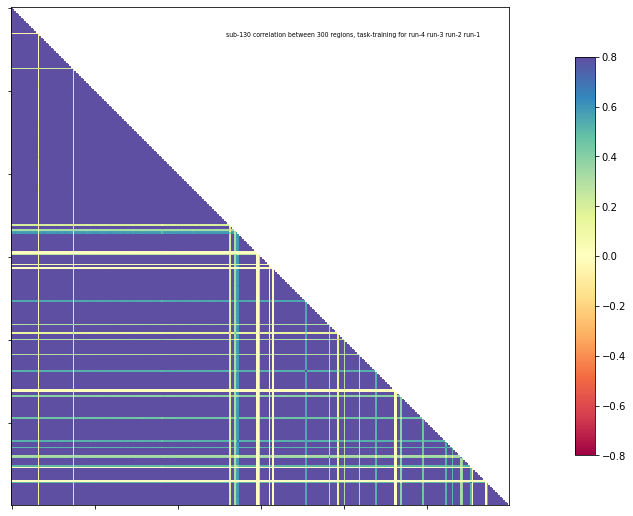


[INFO] sub-131 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.29


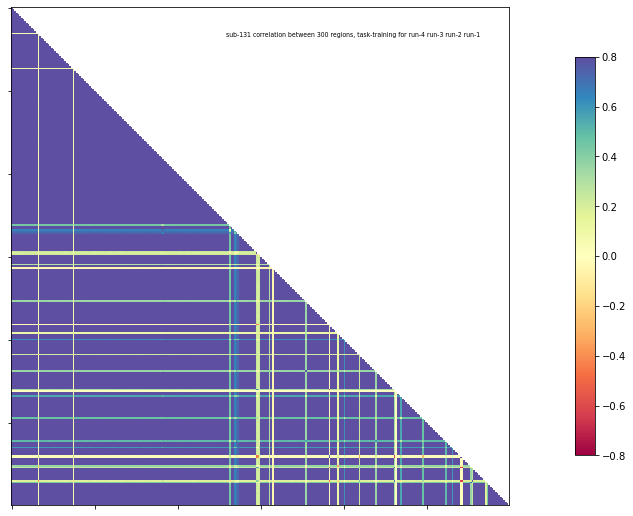


[INFO] sub-132 correlation between 300 regions, task-training for run-3 run-4 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.3


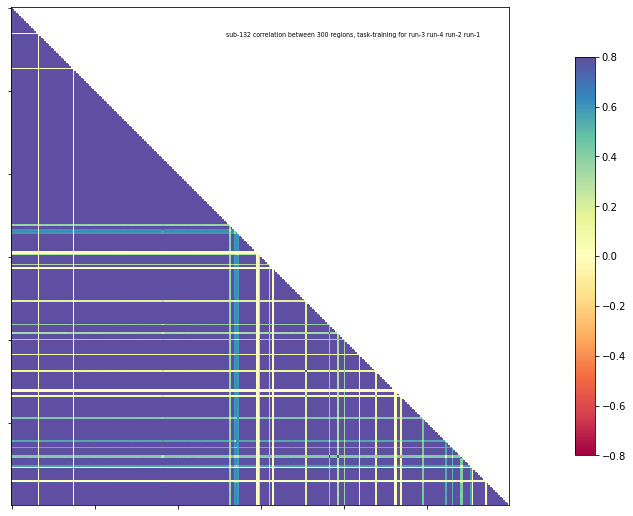


[INFO] sub-133 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.28


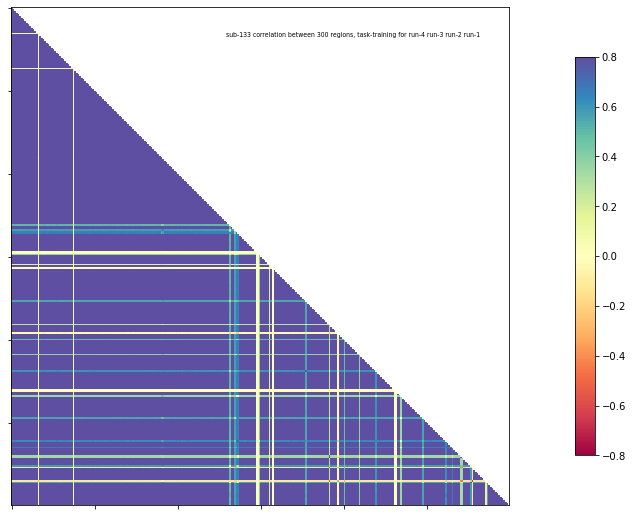


[INFO] sub-134 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.87 	Std: 0.27


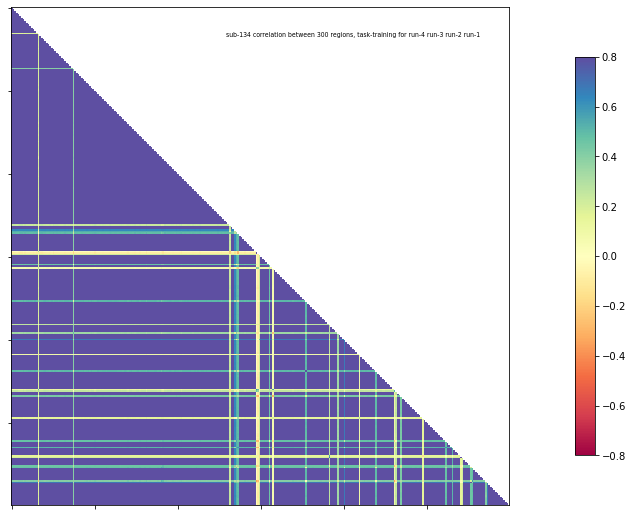


[INFO] sub-135 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.87 	Std: 0.27


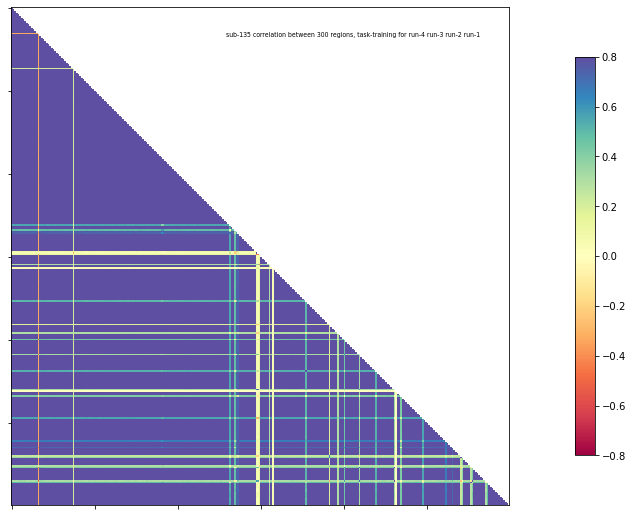


[INFO] sub-136 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.87 	Std: 0.26


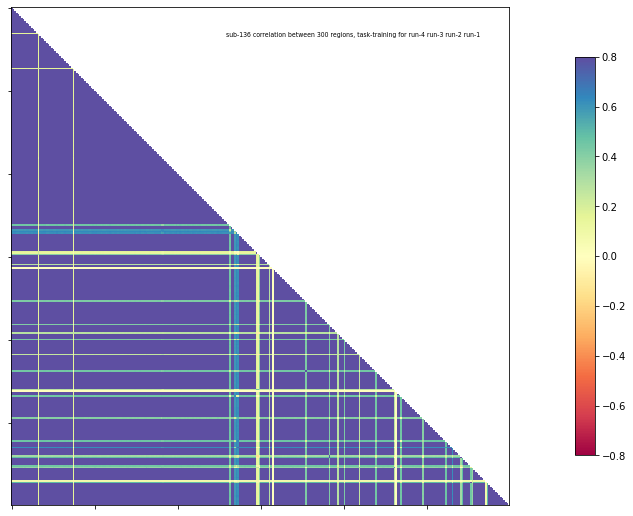


[INFO] sub-137 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.3


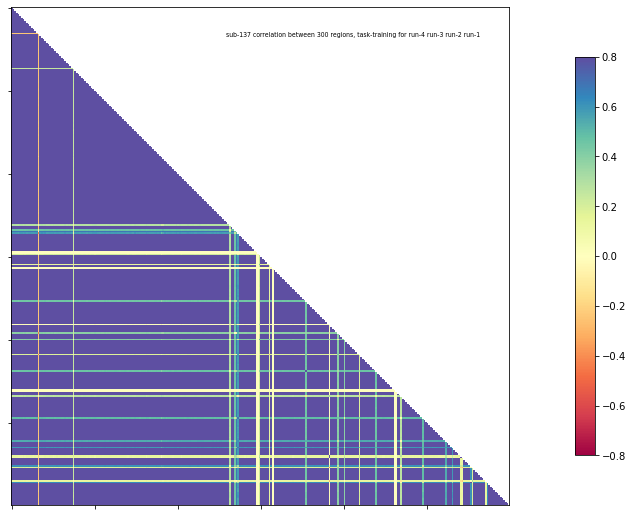


[INFO] sub-138 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.84 	Std: 0.28


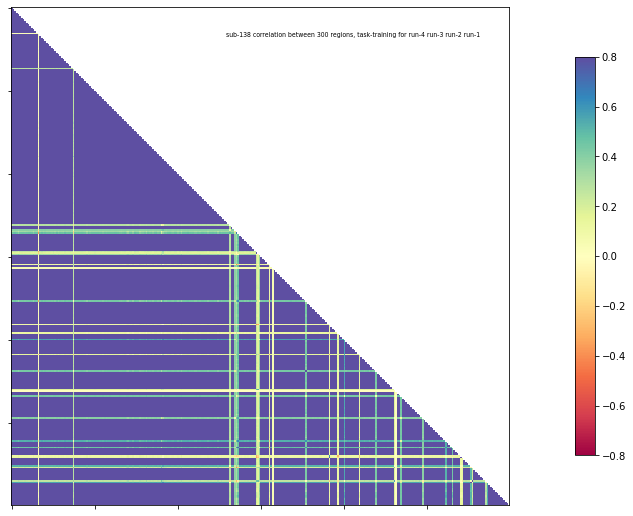


[INFO] sub-140 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.83 	Std: 0.27


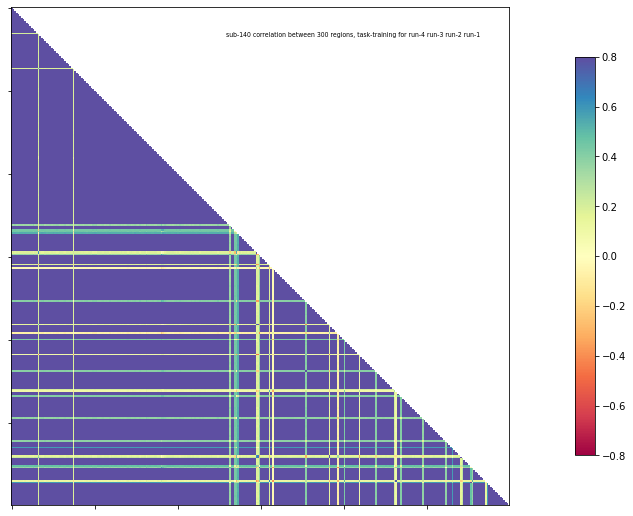


[INFO] sub-141 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.87 	Std: 0.27


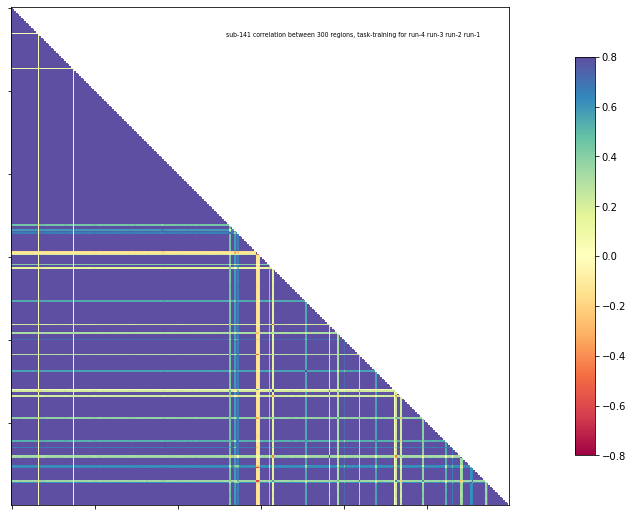


[INFO] sub-142 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


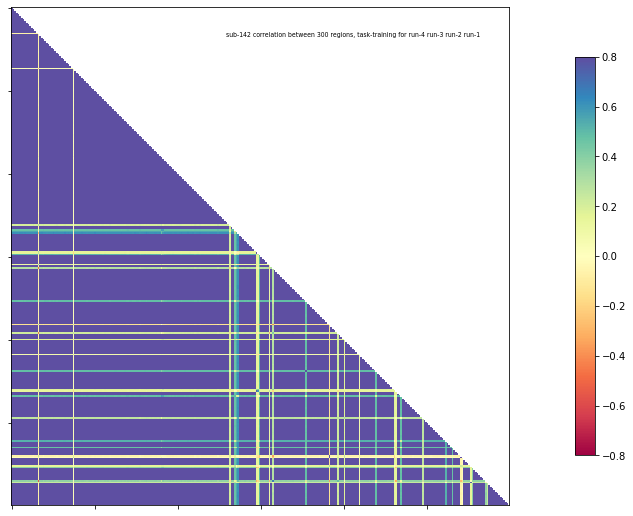


[INFO] sub-143 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.86 	Std: 0.29


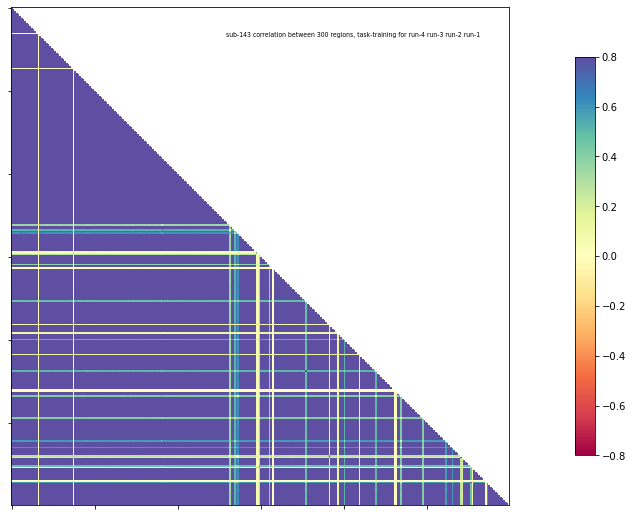


[INFO] sub-144 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.83 	Std: 0.26


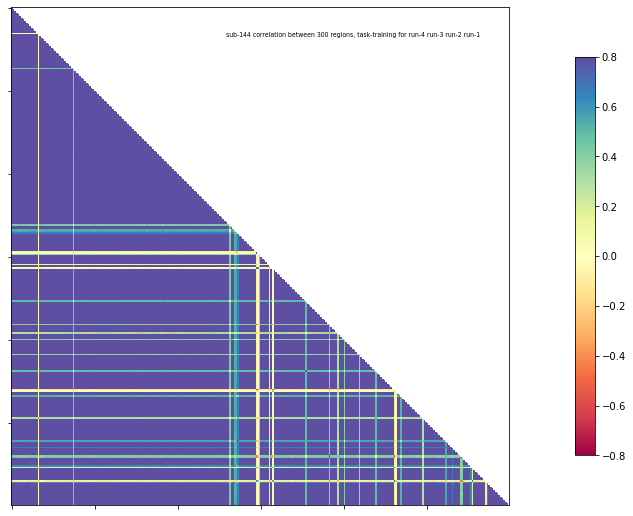


[INFO] sub-145 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.87 	Std: 0.27


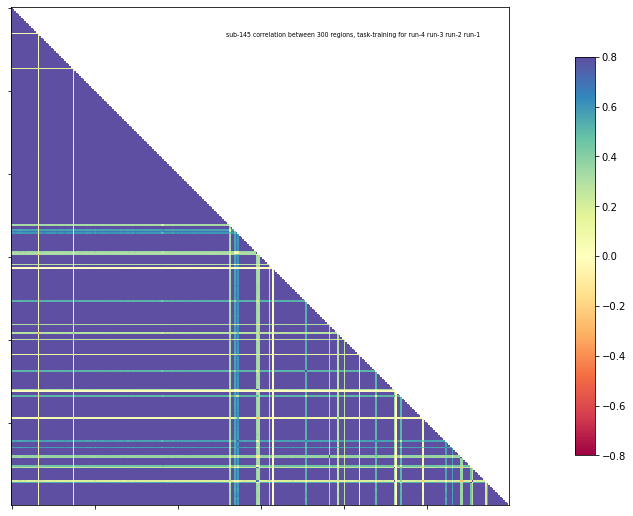


[INFO] sub-146 correlation between 300 regions, task-training for run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


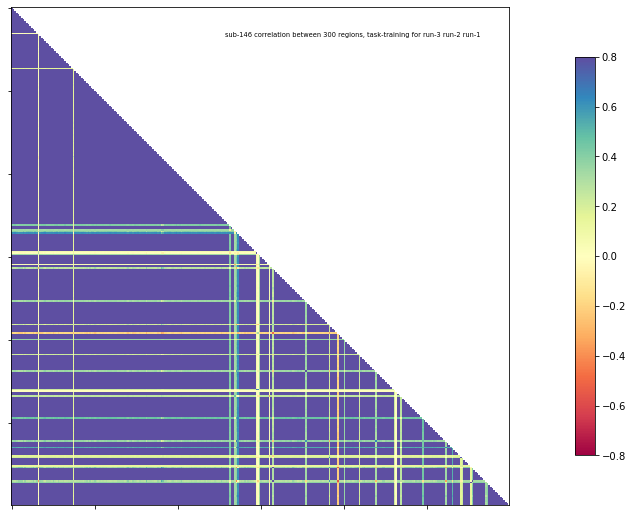


[INFO] sub-147 correlation between 300 regions, task-training for run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.29


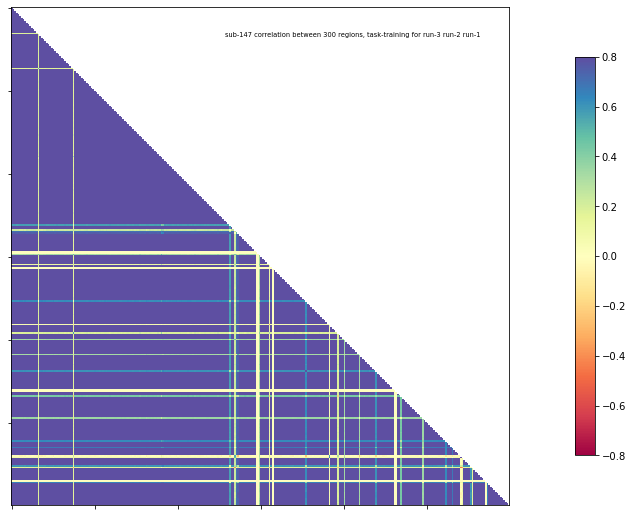


[INFO] sub-149 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.82 	Std: 0.29


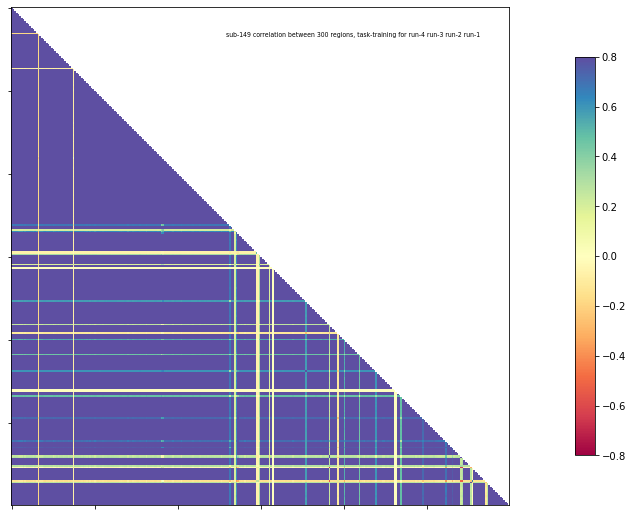


[INFO] sub-150 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.85 	Std: 0.3


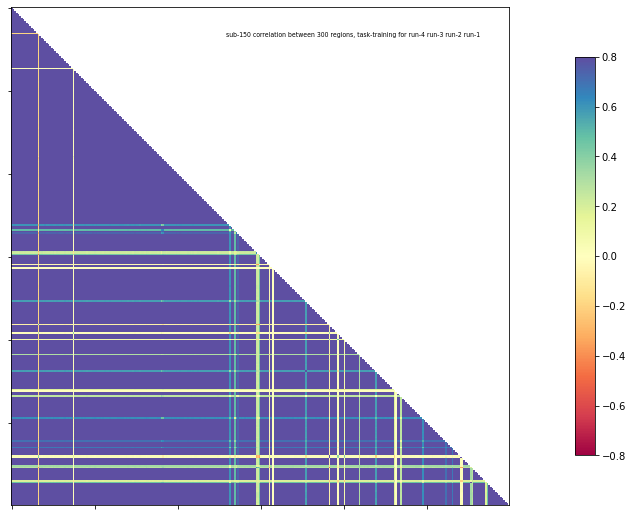


[INFO] sub-159 correlation between 300 regions, task-training for run-4 run-3 run-2 run-1  
[INFO] Mean: 0.88 	Std: 0.27


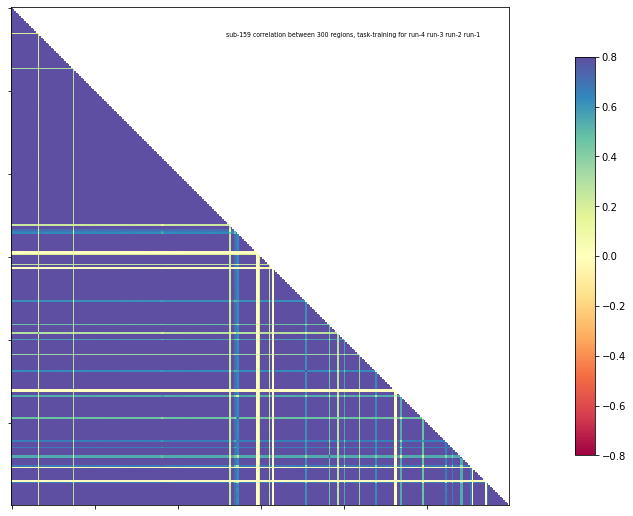

[INFO] process complete.


In [8]:
# loop through dictionary and make matrice for subject with 300 roi timeseries files
concat_sub_timeseries=False
make_fcms=True
average_matrix=True

fc_corr_dict = {}
error_subjects=[]


for subject in sorted(list(data_dict.keys())):
    
    subj_list=[]
    bad_subjects=[]
    correlations = []
    n_regions_extracted=300

    for task in sorted(list(data_dict[subject].keys())):
        if data_dict[subject][task]['bb300'] == 300:
            #print("[INFO] ",task)

            # concat subjects
            if concat_sub_timeseries==True:
                #print("[INFO] starting timeseries concatenation")
                timeseries_concat(subject, task, verbose=False, run_process=True)
                

                
            if 'resting' in task:
                pass
            else:   
                # make fcms
                if make_fcms==True:
                    cmap="Spectral"
                    #timeseries_files=glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/bigbrain300/roi_matrices/funcs_uc/sub-*_*.txt')
                    #print(len(timeseries_files))
                    # Initializing ConnectivityMeasure object with kind='correlation'
                    connectome_measure = ConnectivityMeasure(kind='correlation')#, vectorize=True)

                    # make subject & condition/task connectivtiy matrix
                    correlations= make_subject_fcm(subject,task,correlations)
                
                
            
                
    if average_matrix==True:
        fcm_outpath=os.path.join(data_path,
                                 'timeseries/bigbrain300/funcs_uc/matrices/fcms/averages')
        if len(correlations) >= 2:
            #task1=list(data_dict[subject].keys())[0].split("-")[1]
            #task2=list(data_dict[subject].keys())[1].split("-")[1]
            str1=' '.join(data_dict[subject].keys())
            str1=str1.replace('resting','')
            #print("[INFO] making mean FCM for subject")                

            # make large subject matrix from average of the condition matrices
            mean_matrix = np.mean(correlations, axis=0).reshape(n_regions_extracted, n_regions_extracted)
            #print("[INFO] MEAN FCM: ", mean_correlations.shape)

            #print('[INFO] correlations: \n', mean_matrix)
            ## plotting
            #print('[INFO] Plot of the mean functional connectivity matrix: \n')
            title = '%s correlation between %d regions, task-training for %s '%(subject, 300, str1)#, task1, task2)

            out_img=os.path.join(fcm_outpath, "%s_ses-1_task-training_heatmap.png"%(subject))
            out_avg_file=os.path.join(fcm_outpath, "%s_ses-1_task-training_avg.txt"%(subject))


            # save correlation as textfile
            np.savetxt(out_avg_file, mean_matrix)#.transpose(2,0,1).reshape(3,-1))

            #print("[INFO] Outfile: {}".format(out_avg_file))

            # First plot the matrix
            print('\n[INFO] %s'%title)
            display1 = plotting.plot_matrix(mean_matrix,figure=(9, 7), vmax=.8, vmin=-.8,
                                          title=title, colorbar=True,
                                           cmap='Spectral', tri='lower')


            # We threshold to keep only the 20% of edges with the highest value
            # because the graph is very dense
            #display2 = plotting.plot_connectome(mean_correlations, coords_list,
                    #edge_threshold="90%", title=title)


            #display1.figure.savefig(out_img)
            print('[INFO] Mean: %s \tStd: %s'%(round(np.mean(mean_matrix),2), 
                                        round(np.std(mean_matrix),2)))
            plt.show()







print('[INFO] process complete.')

In [15]:
#data_dict